In [4]:
import os
import argparse
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import time

#### Defining parameters

In [5]:
SEED = 42
DATA_PATH = 'data/'
TURBINES_PATH = DATA_PATH + 'turbines/'
RESULTS_PATH = 'results/'

In [6]:
if not os.path.exists(DATA_PATH):
    raise argparse.ArgumentTypeError("Invalit path to 'data/' directory.")
if not os.path.exists(TURBINES_PATH):
    raise argparse.ArgumentTypeError("Invalit path to 'data/turbines/' directory.")
os.makedirs(RESULTS_PATH, exist_ok=True)
random.seed(SEED) # set to reproduce the results

# Data Processing

In [7]:
# helper functions
def merge_data(dir_path):
    files_path = os.listdir(dir_path)
    df_acc = []
    for file_name in files_path:
        file_path = os.path.join(dir_path, file_name)
        df_temp = pd.read_csv(file_path)
        # df_temp['turbine_id'] = file_name.split("/")[-1].split(".")[0] # there already exists a column called Wind_turbine_name
        df_acc.append(df_temp)
    return pd.concat(df_acc, ignore_index=True)

def sanity_check(df, print_report=False):
    report = ''
    checked = True
    nulls_df = df.isnull().sum()

    if nulls_df.sum() != 0:
        checked = False
        report += 'There are null values in the dataset.\n'
    else:
        report += 'No null values found.\n'

    if print_report:
        print(report + f'Sanity check passed: {checked}')

    return checked

In [8]:
df = merge_data(TURBINES_PATH)
df

Date_time  Date_time_nr Wind_turbine_name  Ba_avg  \
0        2013-01-01T00:00:00+01:00    1356994800            R80721   -1.01   
1        2013-01-01T00:10:00+01:00    1356995400            R80721   -1.02   
2        2013-01-01T00:20:00+01:00    1356996000            R80721   -1.02   
3        2013-01-01T00:30:00+01:00    1356996600            R80721   -1.03   
4        2013-01-01T00:40:00+01:00    1356997200            R80721   -1.03   
...                            ...           ...               ...     ...   
1045830  2018-01-12T23:20:00+01:00    1515795600            R80711   -0.83   
1045831  2018-01-12T23:30:00+01:00    1515796200            R80711   -0.15   
1045832  2018-01-12T23:40:00+01:00    1515796800            R80711    0.03   
1045833  2018-01-12T23:50:00+01:00    1515797400            R80711    0.48   
1045834  2018-01-13T00:00:00+01:00    1515798000            R80711   -0.06   

              P_avg      Q_avg     Ya_avg     Yt_avg  Ws1_avg  Ws2_avg  ...  \
0         679.69000  75.389999  165.10001  15.010000     7.13     7.38  ...   
1         867.40997  78.320000  165.10001  20.030001     7.60     7.93  ...   
2         948.92999  83.230003  165.10001  21.410000     7.90     8.13  ...   
3        1099.06010  82.699997  165.10001  22.020000     8.54     8.68  ...   
4        1003.62000  86.129997  165.10001  22.350000     8.49     8.60  ...   
...             ...        ...        ...        ...      ...      ...  ...   
1045830    68.42000  16.010000   55.98000  23.050000     4.18     4.34  ...   
1045831    27.36000   4.480000   55.98000  23.470000     3.51     3.64  ...   
1045832    20.98000   3.040000   55.98000  23.870000     3.47     3.63  ...   
1045833     0.00000   0.010000   55.98000  24.300000     1.42     2.81  ...   
1045834    24.73000  11.240000   55.98000  24.800000     3.38     3.66  ...   

            Rs_avg    Rbt_avg     Rm_avg  temp  pressure  humidity  \
0        16.360001  25.889999  3759.9700  5.39    1011.0      75.0   
1        17.000000  25.900000  4638.0298  5.39    1011.0      75.0   
2        17.120001  25.900000  5046.3501  5.39    1011.0      75.0   
3        17.170000  25.930000  5831.7202  5.39    1011.0      75.0   
4        17.090000  25.990000  5341.3301  5.39    1011.0      75.0   
...            ...        ...        ...   ...       ...       ...   
1045830   9.480000  23.340000   648.7700  1.86    1025.0      93.0   
1045831   9.230000  23.360000   269.3600  1.86    1025.0      93.0   
1045832   9.230000  23.340000   206.5400  1.86    1025.0      93.0   
1045833   9.230000  23.370000   -57.3900  1.86    1025.0      93.0   
1045834   9.230000  23.390000   243.4000  1.96    1024.0     100.0   

         wind_speed  wind_deg  rain_1h  snow_1h  
0              5.66     180.0      0.0      0.0  
1              5.66     180.0      0.0      0.0  
2              5.66     180.0      0.0      0.0  
3              5.66     180.0      0.0      0.0  
4              5.66     180.0      0.0      0.0  
...             ...       ...      ...      ...  
1045830        3.09      80.0      0.0      0.0  
1045831        3.09      80.0      0.0      0.0  
1045832        3.09      80.0      0.0      0.0  
1045833        3.09      80.0      0.0      0.0  
1045834        1.54      60.0      0.0      0.0  

[1045835 rows x 24 columns]

## Type processing

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045835 entries, 0 to 1045834
Data columns (total 24 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Date_time          1045835 non-null  object 
 1   Date_time_nr       1045835 non-null  int64  
 2   Wind_turbine_name  1045835 non-null  object 
 3   Ba_avg             1045835 non-null  float64
 4   P_avg              1045835 non-null  float64
 5   Q_avg              1045835 non-null  float64
 6   Ya_avg             1045835 non-null  float64
 7   Yt_avg             1045835 non-null  float64
 8   Ws1_avg            1045835 non-null  float64
 9   Ws2_avg            1045835 non-null  float64
 10  Ws_avg             1045835 non-null  float64
 11  Wa_avg             1045835 non-null  float64
 12  Va_avg             1045835 non-null  float64
 13  Ot_avg             1045835 non-null  float64
 14  Rs_avg             1045835 non-null  float64
 15  Rbt_avg            1045835 non-n

In [10]:
# convert the date_time column to a date time type
df['Date_time'] = pd.to_datetime(df['Date_time'], format='%Y-%m-%dT%H:%M:%S%z', utc=True).dt.tz_convert('Europe/Berlin')
df = df.set_index('Date_time')

## Sanity Check

In [11]:
is_checked = sanity_check(df, print_report=True)
if not is_checked:
    raise Exception("Data does not pass basic sanity checks.")

No null values found.
Sanity check passed: True


## Explore feature names and meaning

In [12]:
data_desc_path = os.path.join(DATA_PATH, 'data_description.csv')
data_description = pd.read_csv(data_desc_path, sep=";")
col_names = [col.split('_')[0] for col in df.columns if col.split('_')[0] in data_description['Variable_name'].tolist()]
data_description_filtered = data_description[data_description['Variable_name'].isin(col_names)]
data_description_filtered

Variable_name         Variable_long_name Unit_long_name  \
0              Q             Reactive_power           kVAr   
1             Ws                 Wind_speed            m/s   
4             Ot        Outdoor_temperature          deg_C   
5            Ws2               Wind_speed_2            m/s   
11            Yt        Nacelle_temperature          deg_C   
13            Ya              Nacelle_angle            deg   
14            Rm                     Torque             Nm   
16            Rs                Rotor_speed            rpm   
18            Wa    Absolute_wind_direction            deg   
19            Ba                Pitch_angle            deg   
21            Va              Vane_position            deg   
25           Ws1               Wind_speed_1            m/s   
27             P               Active_power             kW   
33           Rbt  Rotor_bearing_temperature          deg_C   

                             Comment  
0                                NaN  
1                 Average wind speed  
4                                NaN  
5   Second anemometer on the nacelle  
11                               NaN  
13                               NaN  
14                               NaN  
16                               NaN  
18                               NaN  
19                               NaN  
21                               NaN  
25   First anemometer on the nacelle  
27                               NaN  
33                               NaN

## Data Visualization

In [13]:
filtered_df = df.drop(columns=['Date_time_nr'])
filtered_df

Wind_turbine_name  Ba_avg       P_avg      Q_avg  \
Date_time                                                                    
2013-01-01 00:00:00+01:00            R80721   -1.01   679.69000  75.389999   
2013-01-01 00:10:00+01:00            R80721   -1.02   867.40997  78.320000   
2013-01-01 00:20:00+01:00            R80721   -1.02   948.92999  83.230003   
2013-01-01 00:30:00+01:00            R80721   -1.03  1099.06010  82.699997   
2013-01-01 00:40:00+01:00            R80721   -1.03  1003.62000  86.129997   
...                                     ...     ...         ...        ...   
2018-01-12 23:20:00+01:00            R80711   -0.83    68.42000  16.010000   
2018-01-12 23:30:00+01:00            R80711   -0.15    27.36000   4.480000   
2018-01-12 23:40:00+01:00            R80711    0.03    20.98000   3.040000   
2018-01-12 23:50:00+01:00            R80711    0.48     0.00000   0.010000   
2018-01-13 00:00:00+01:00            R80711   -0.06    24.73000  11.240000   

                              Ya_avg     Yt_avg  Ws1_avg  Ws2_avg  Ws_avg  \
Date_time                                                                   
2013-01-01 00:00:00+01:00  165.10001  15.010000     7.13     7.38    7.25   
2013-01-01 00:10:00+01:00  165.10001  20.030001     7.60     7.93    7.77   
2013-01-01 00:20:00+01:00  165.10001  21.410000     7.90     8.13    8.01   
2013-01-01 00:30:00+01:00  165.10001  22.020000     8.54     8.68    8.61   
2013-01-01 00:40:00+01:00  165.10001  22.350000     8.49     8.60    8.55   
...                              ...        ...      ...      ...     ...   
2018-01-12 23:20:00+01:00   55.98000  23.050000     4.18     4.34    4.26   
2018-01-12 23:30:00+01:00   55.98000  23.470000     3.51     3.64    3.58   
2018-01-12 23:40:00+01:00   55.98000  23.870000     3.47     3.63    3.55   
2018-01-12 23:50:00+01:00   55.98000  24.300000     1.42     2.81    2.12   
2018-01-13 00:00:00+01:00   55.98000  24.800000     3.38     3.66    3.52   

                           Wa_avg  ...     Rs_avg    Rbt_avg     Rm_avg  temp  \
Date_time                          ...                                          
2013-01-01 00:00:00+01:00  163.16  ...  16.360001  25.889999  3759.9700  5.39   
2013-01-01 00:10:00+01:00  162.42  ...  17.000000  25.900000  4638.0298  5.39   
2013-01-01 00:20:00+01:00  165.98  ...  17.120001  25.900000  5046.3501  5.39   
2013-01-01 00:30:00+01:00  168.03  ...  17.170000  25.930000  5831.7202  5.39   
2013-01-01 00:40:00+01:00  171.48  ...  17.090000  25.990000  5341.3301  5.39   
...                           ...  ...        ...        ...        ...   ...   
2018-01-12 23:20:00+01:00   61.01  ...   9.480000  23.340000   648.7700  1.86   
2018-01-12 23:30:00+01:00   56.38  ...   9.230000  23.360000   269.3600  1.86   
2018-01-12 23:40:00+01:00   56.71  ...   9.230000  23.340000   206.5400  1.86   
2018-01-12 23:50:00+01:00   56.74  ...   9.230000  23.370000   -57.3900  1.86   
2018-01-13 00:00:00+01:00   60.66  ...   9.230000  23.390000   243.4000  1.96   

                           pressure  humidity  wind_speed  wind_deg  rain_1h  \
Date_time                                                                      
2013-01-01 00:00:00+01:00    1011.0      75.0        5.66     180.0      0.0   
2013-01-01 00:10:00+01:00    1011.0      75.0        5.66     180.0      0.0   
2013-01-01 00:20:00+01:00    1011.0      75.0        5.66     180.0      0.0   
2013-01-01 00:30:00+01:00    1011.0      75.0        5.66     180.0      0.0   
2013-01-01 00:40:00+01:00    1011.0      75.0        5.66     180.0      0.0   
...                             ...       ...         ...       ...      ...   
2018-01-12 23:20:00+01:00    1025.0      93.0        3.09      80.0      0.0   
2018-01-12 23:30:00+01:00    1025.0      93.0        3.09      80.0      0.0   
2018-01-12 23:40:00+01:00    1025.0      93.0        3.09      80.0      0.0   
2018-01-12 23:50:00+01:00    1025.0      93.0        3.09      80.0      0.

#### Plot Feature Distributions

/tmp/ipykernel_734/394376822.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/394376822.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'
/tmp/ipykernel_734/394376822.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else co

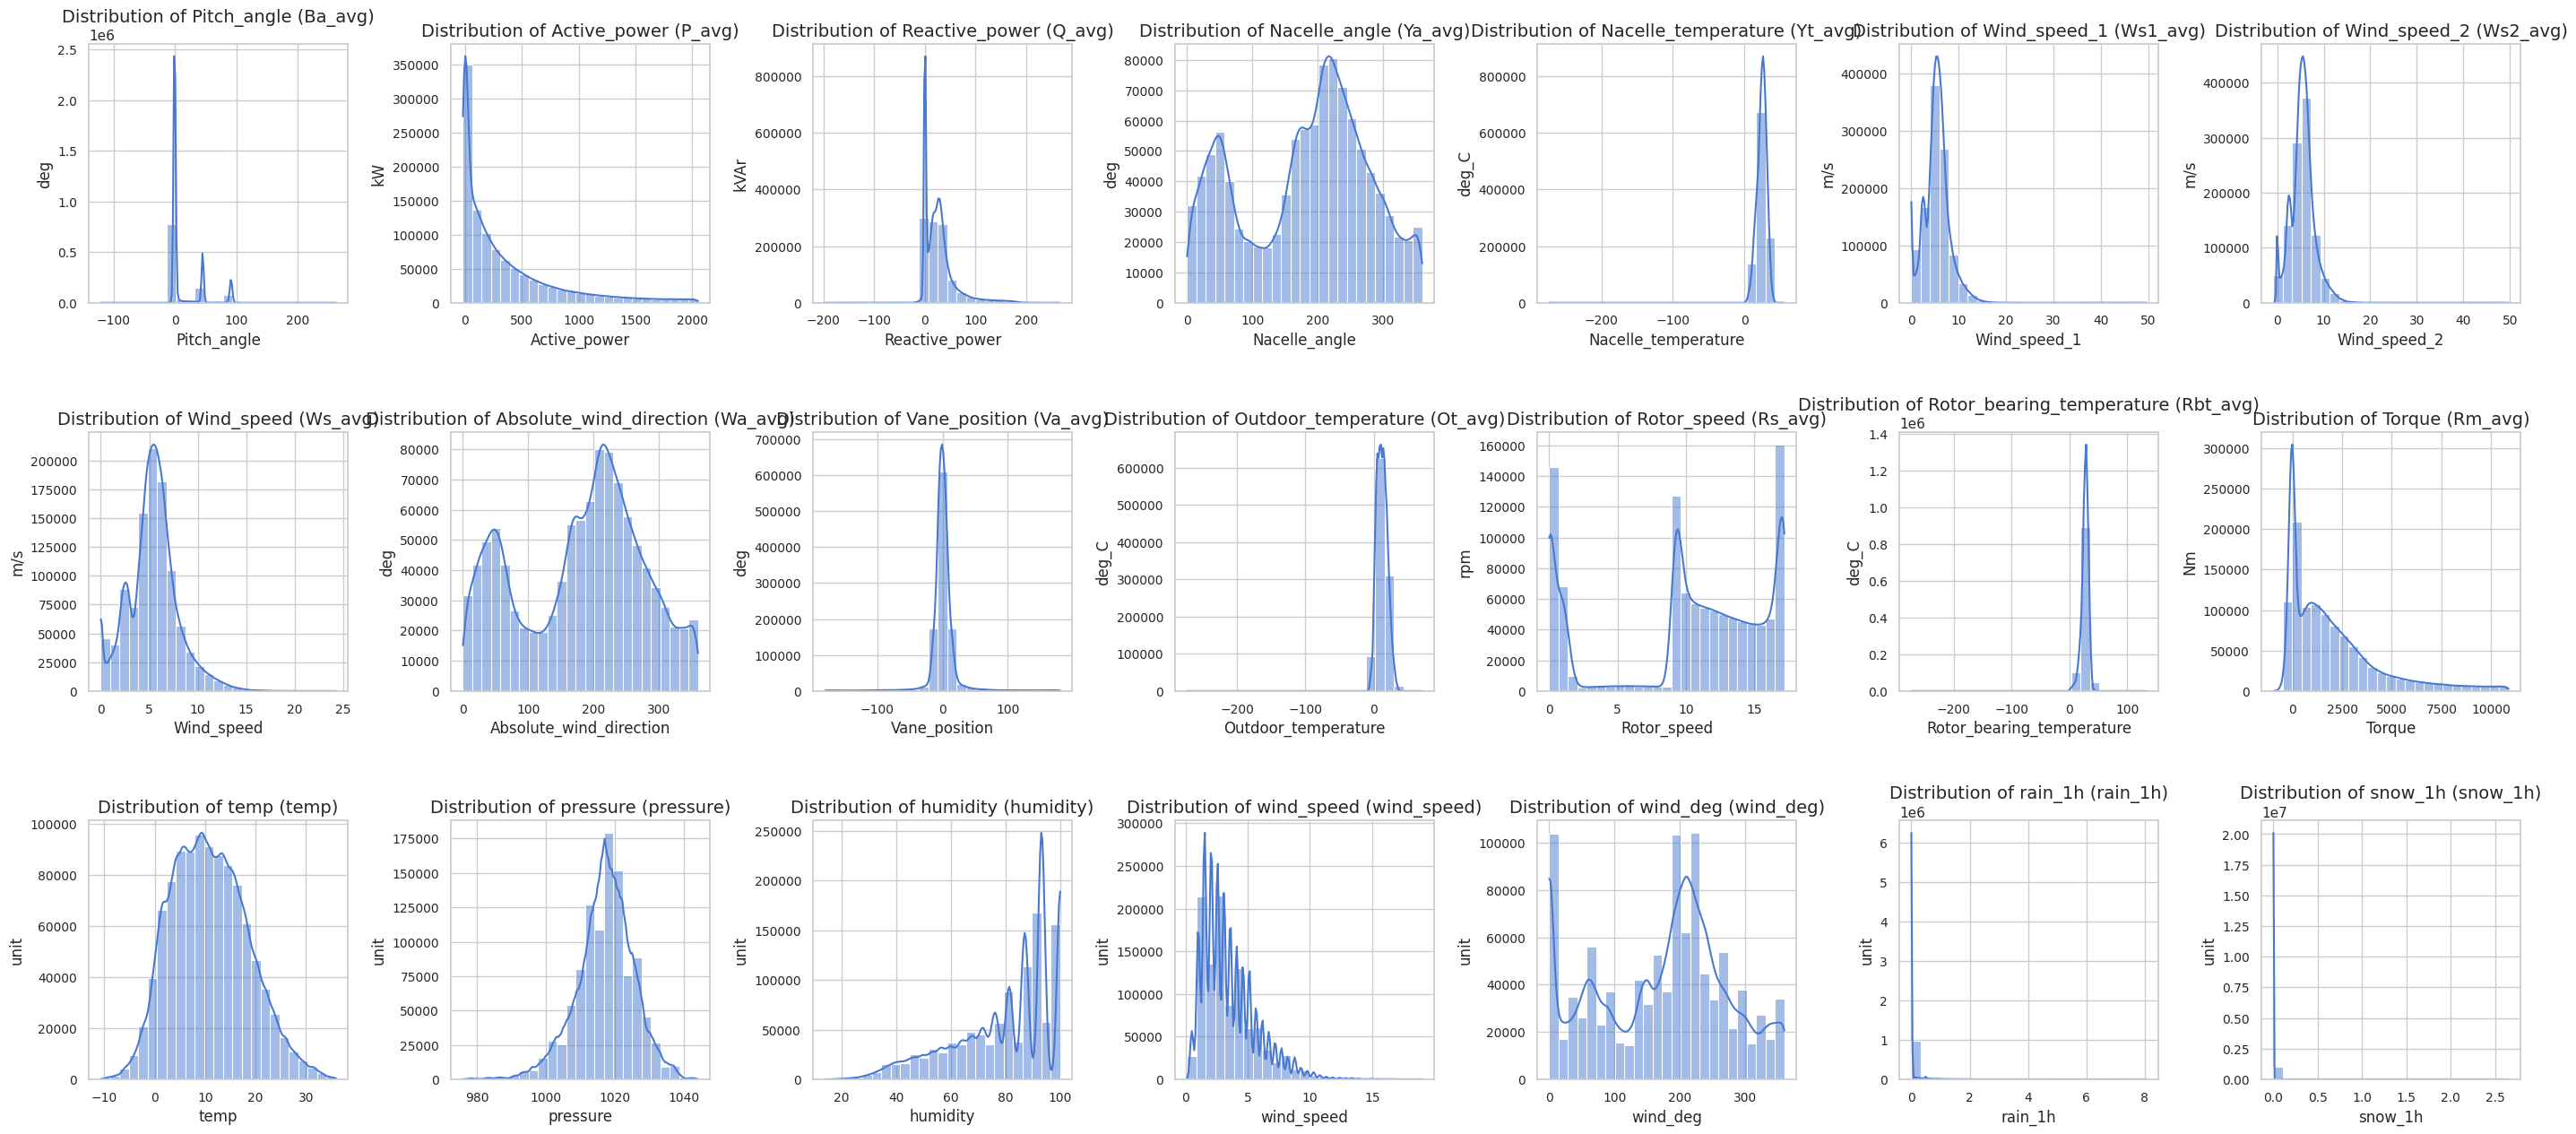

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", palette="muted")

# we have 21 features to plot, therefore (3x7) plots
nrows = 3
ncols = 7

fig, axes = plt.subplots(nrows, ncols, figsize=(35, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.5})

for i, col_name in enumerate(filtered_df.columns):

    if col_name == 'Wind_turbine_name': # ignore string feature
        continue

    row = (i-1) // ncols
    col = (i-1) % ncols

    filtered_dd = data_description[data_description['Variable_name'] == col_name.split('_')[0]]
    long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
    unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'

    sns.histplot(filtered_df[col_name], bins=25, kde=True, ax=axes[row, col])
    axes[row, col].set_xlabel(long_name, fontsize=12)
    axes[row, col].set_ylabel(unit_name, fontsize=12)
    axes[row, col].set_title(f'Distribution of {long_name} ({col_name})', fontsize=14)

    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# # remove any unused subplots
# for j in range(i + 1, nrows * ncols):
#     fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### General observation of the features

- *Non-Gaussian Distributions*: Many of the features exhibit non-normal distributions. This is common in real-world data.
- *Skewness*: Some distributions are heavily skewed (e.g., P_avg, Q_avg, Rm_avg). This means there are more data points concentrated on one side of the distribution.
- *Outliers*: A few distributions have potential outliers (e.g., Ba_avg, Rbt_avg). These points might need further investigation as they could be measurement errors or genuine anomalies.

#### Specific Feature Insights

- *Pitch Angle (Ba_avg) and Rotor Torque (Rm_avg)*
    - The negative skewness suggests that the pitch angles and torque are often low, with a few instances of higher values. This is expected for wind turbines, as they typically operate at lower pitch angles and torque values to maximize energy capture in normal wind conditions.The concentration of values around -1 for pitch angle and a similar pattern in rotor torque indicate a common operating point for the turbine.
- *Power Output (P_avg, Q_avg)*
    - Both distributions are heavily right-skewed, indicating that the turbine primarily operates at lower power levels, with occasional bursts of higher power when wind conditions are favorable.The long tail on the right side suggests that there's a limit to the maximum power output, likely due to physical constraints of the turbine or regulatory limits.
- *Wind Speed (Ws_avg, Ws1_avg, Ws2_avg)*
    - The distributions show a right-skewed pattern, typical of wind speed data. The turbines often experience lower wind speeds, with less frequent occurrences of higher wind speeds.
- *Temperatures (Ot_avg, Yt_avg, Rbt_avg)*
    - These seem to follow more of a normal distribution, which is expected for temperature data.The range of values reflects the varying environmental conditions the turbines are exposed to.
- *Weather Conditions (temp, pressure, humidity, wind_speed, wind_deg, rain_1h, snow_1h)*
    - These variables show a variety of distributions, indicating the range of weather conditions the turbines encounter.The plot for rain_1h and snow_1h show that there were very few occurrences of rain and snow.

#### Visualization of time series data per turbine

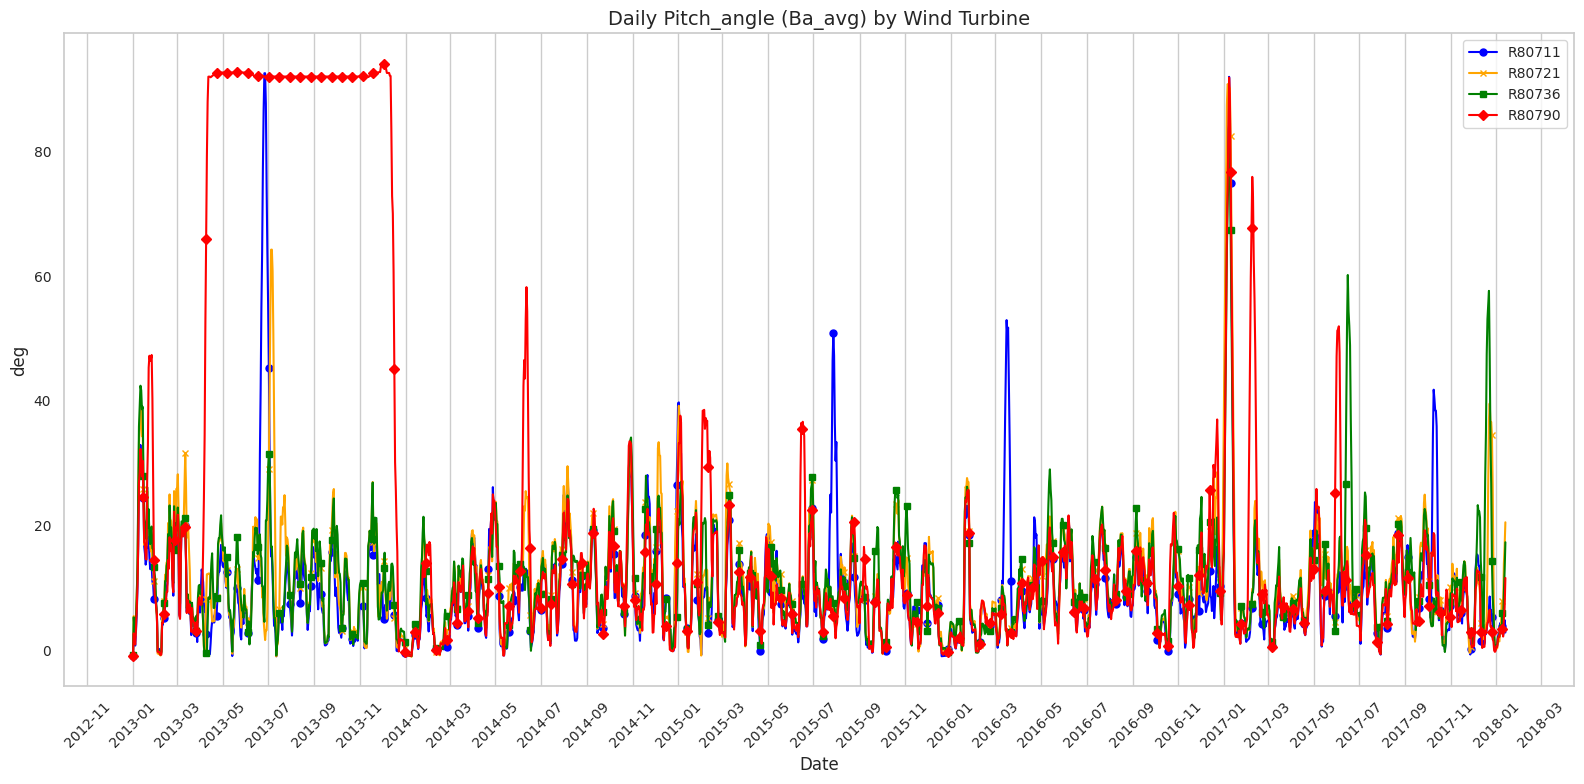

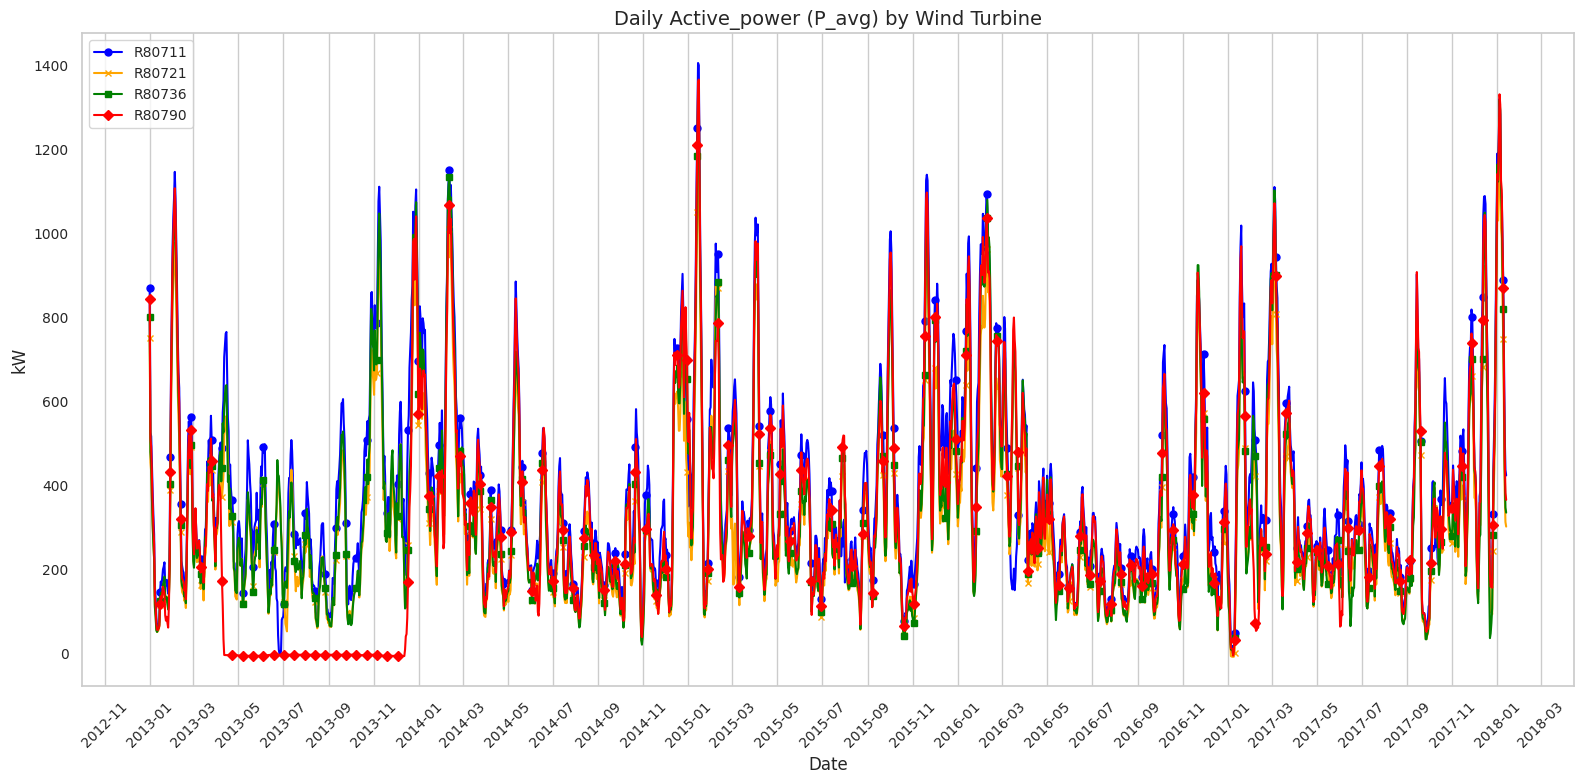

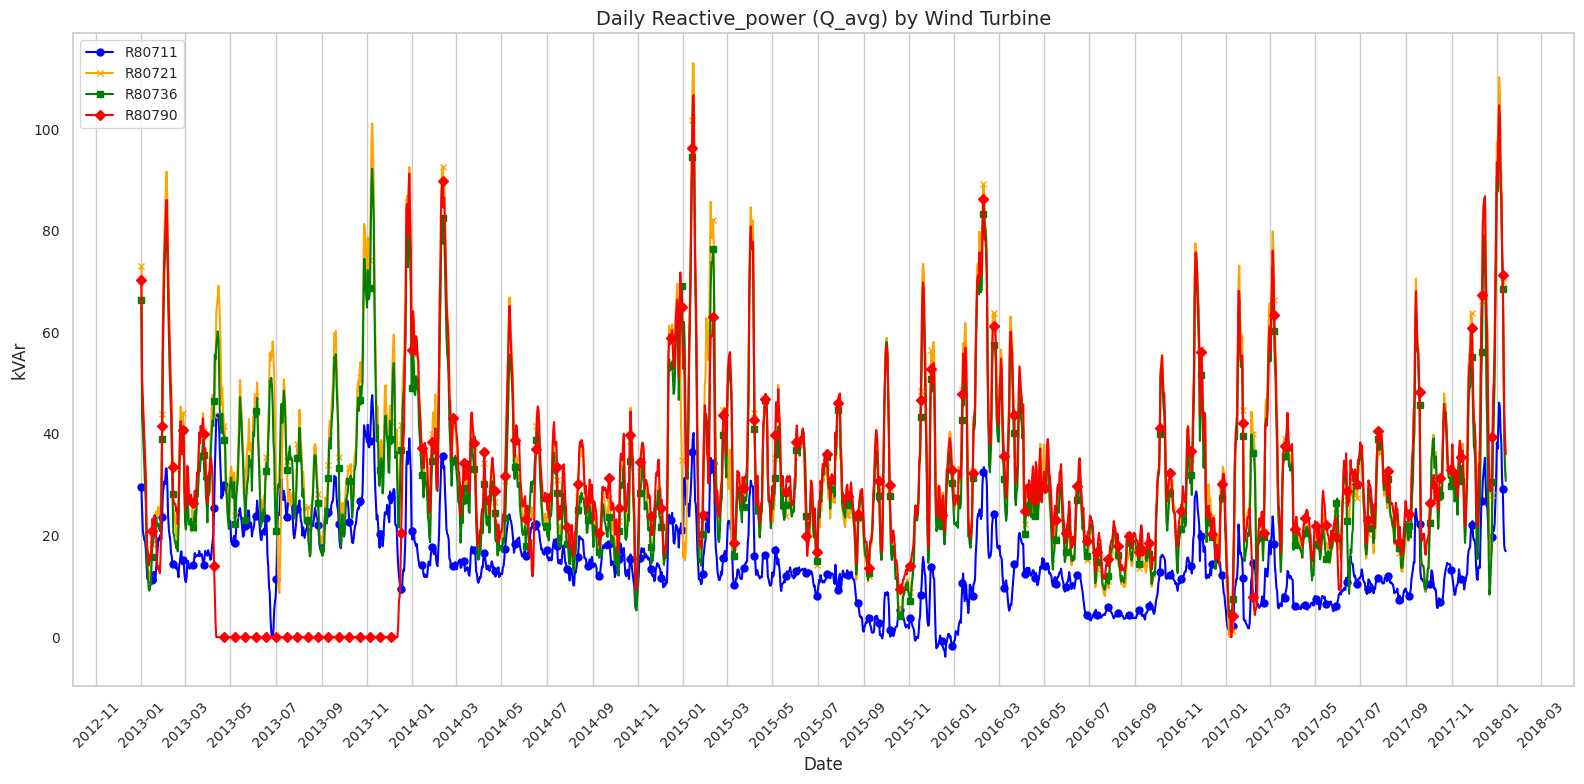

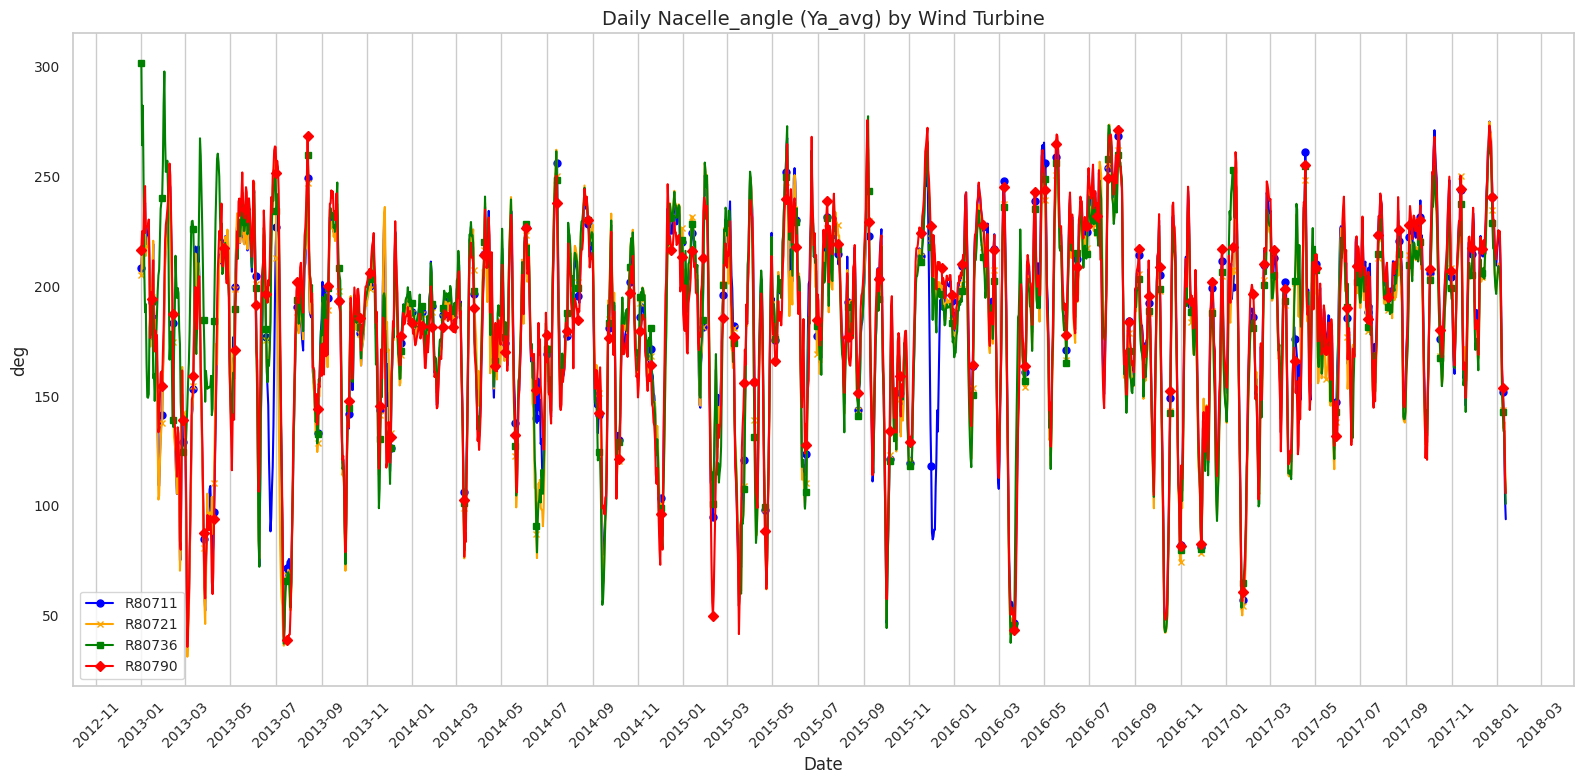

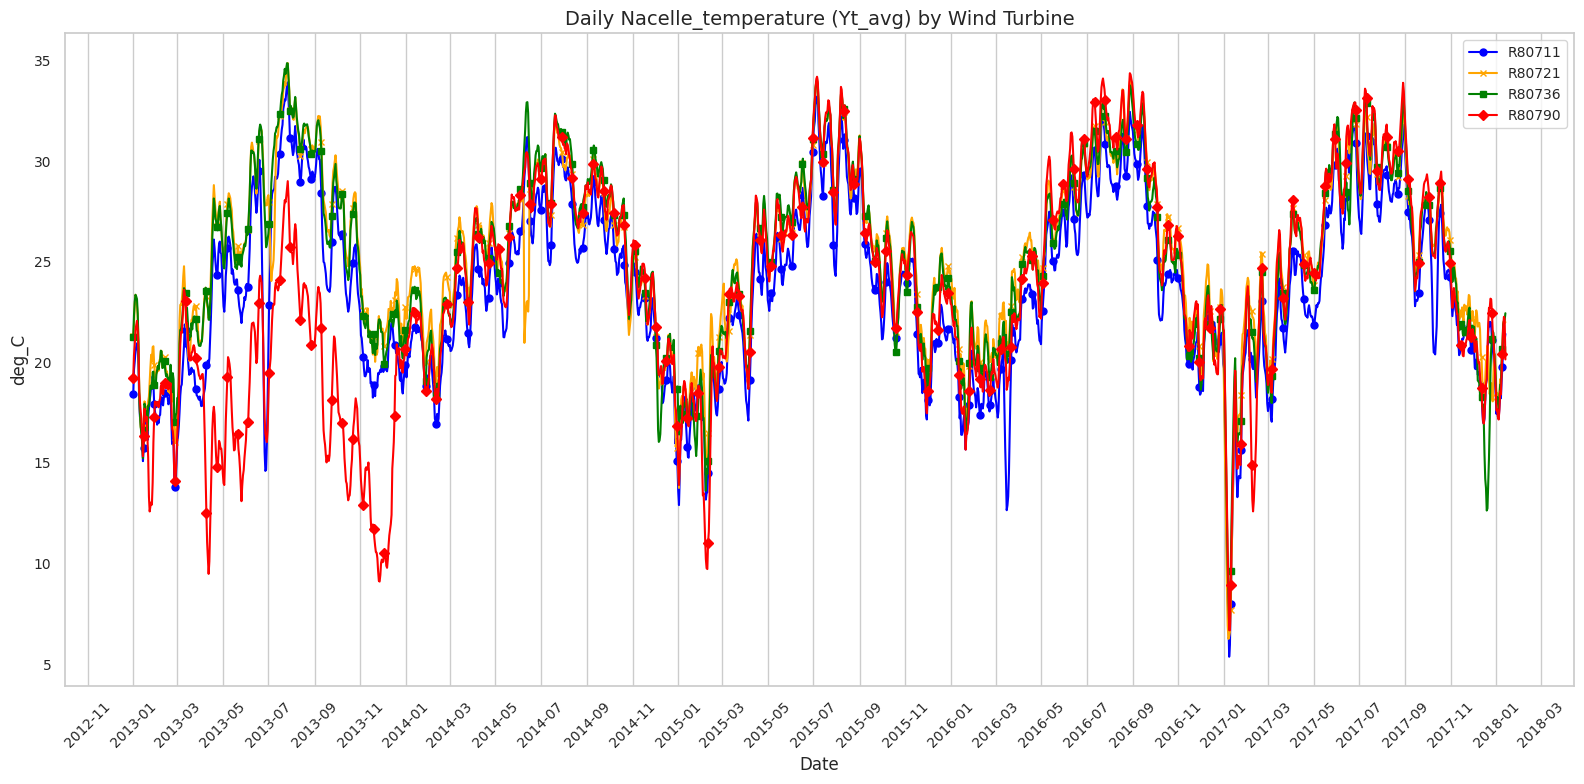

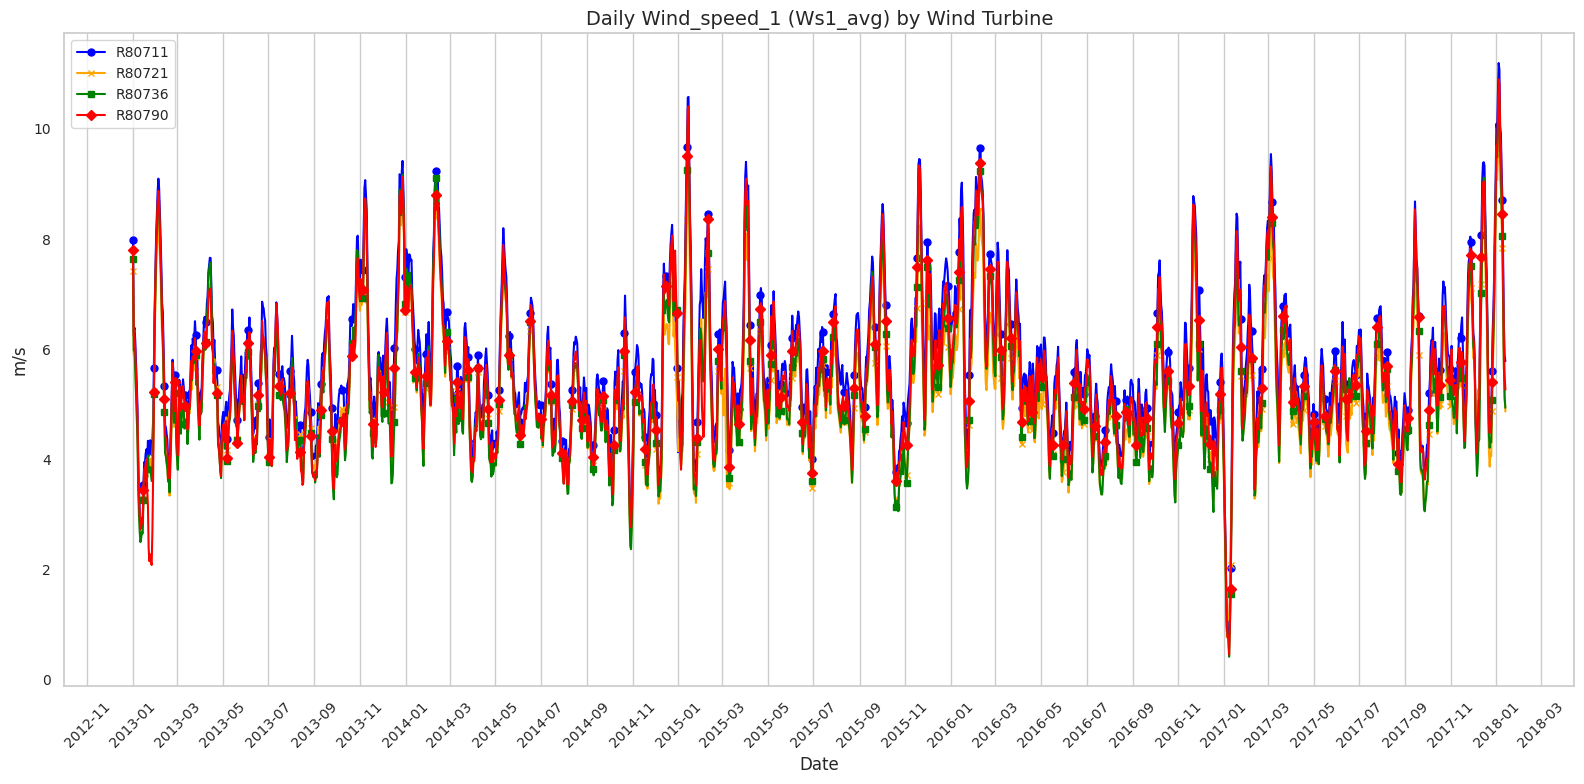

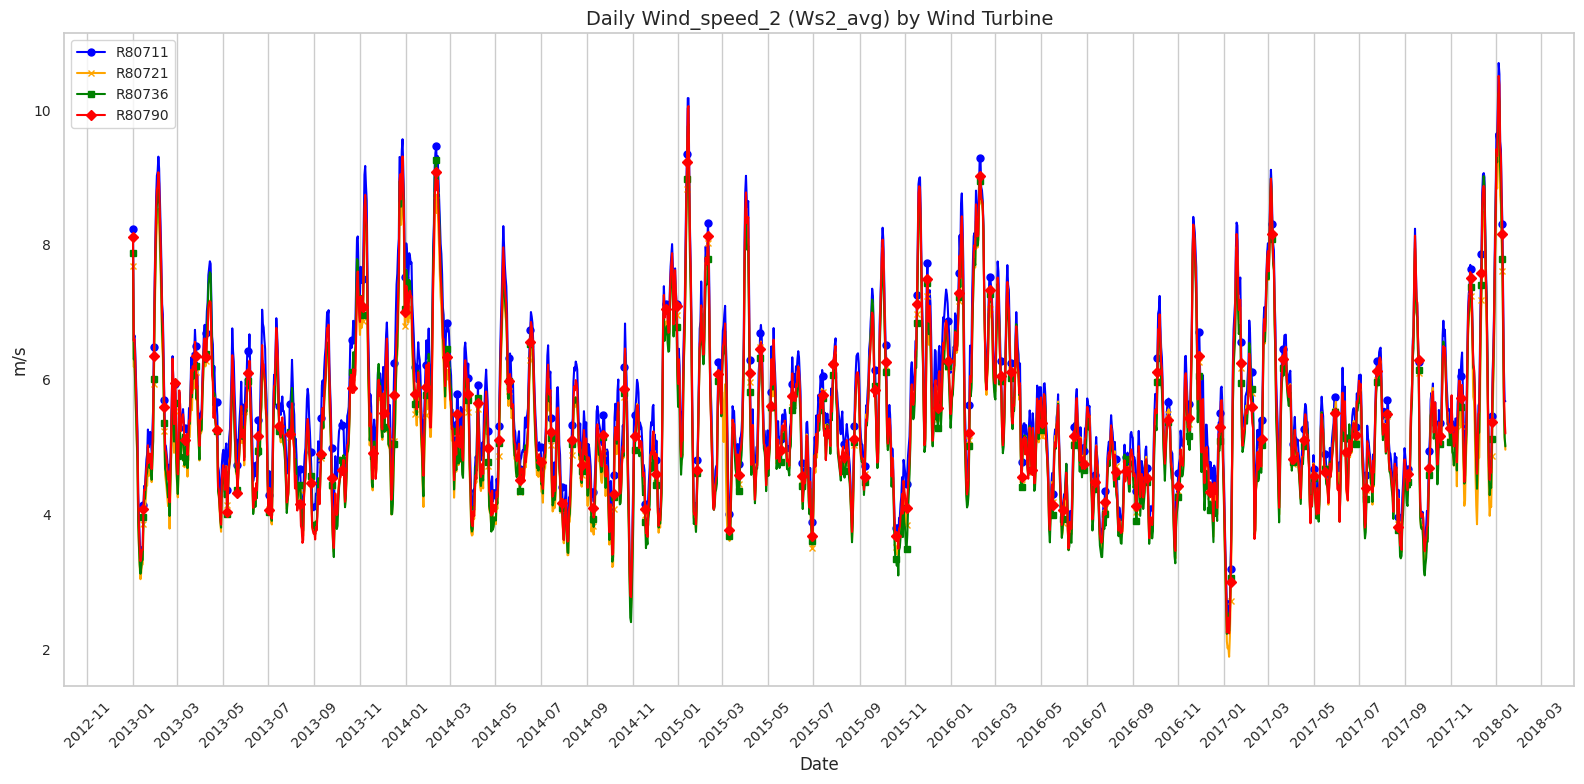

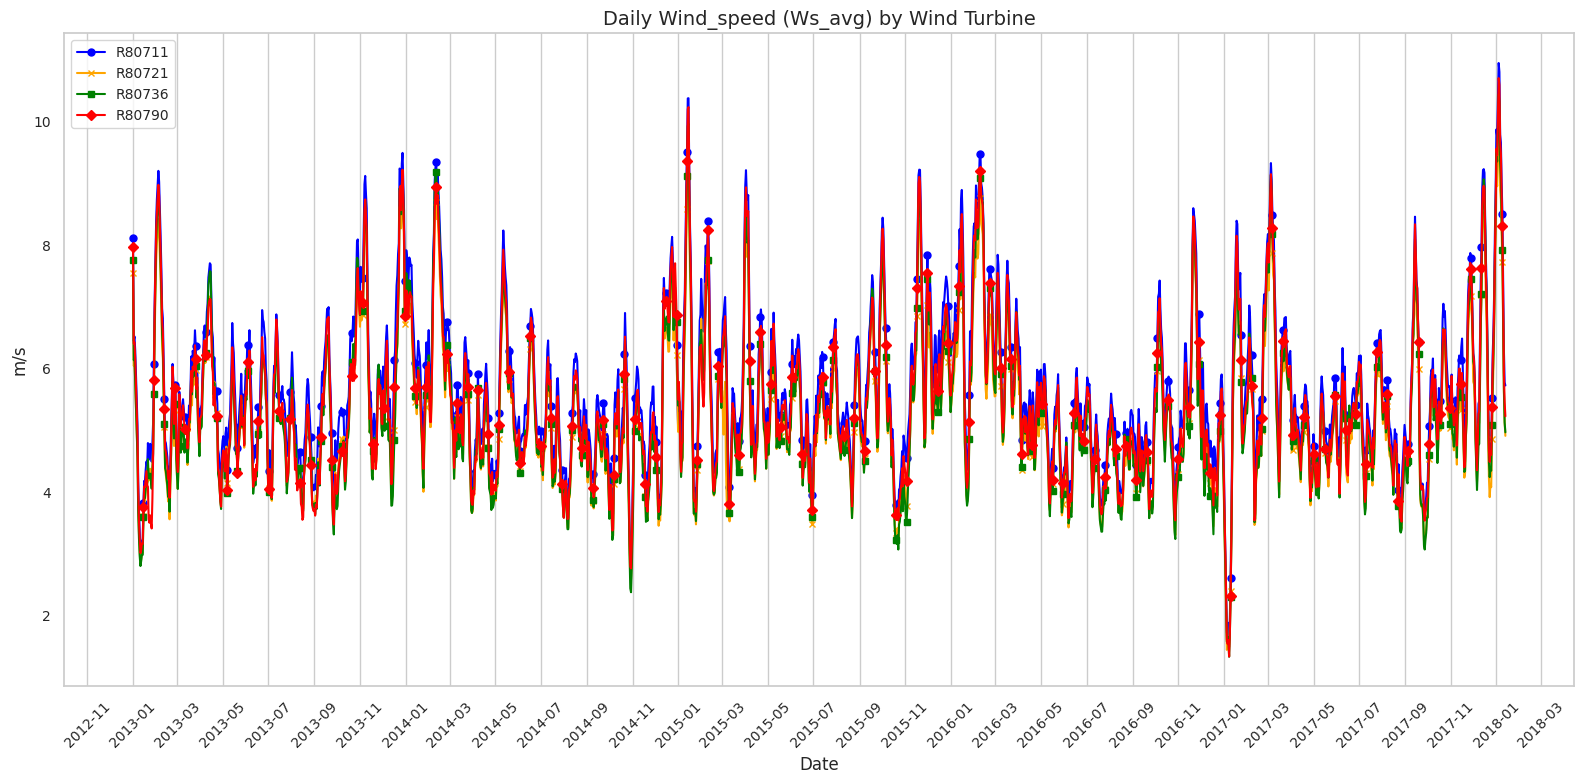

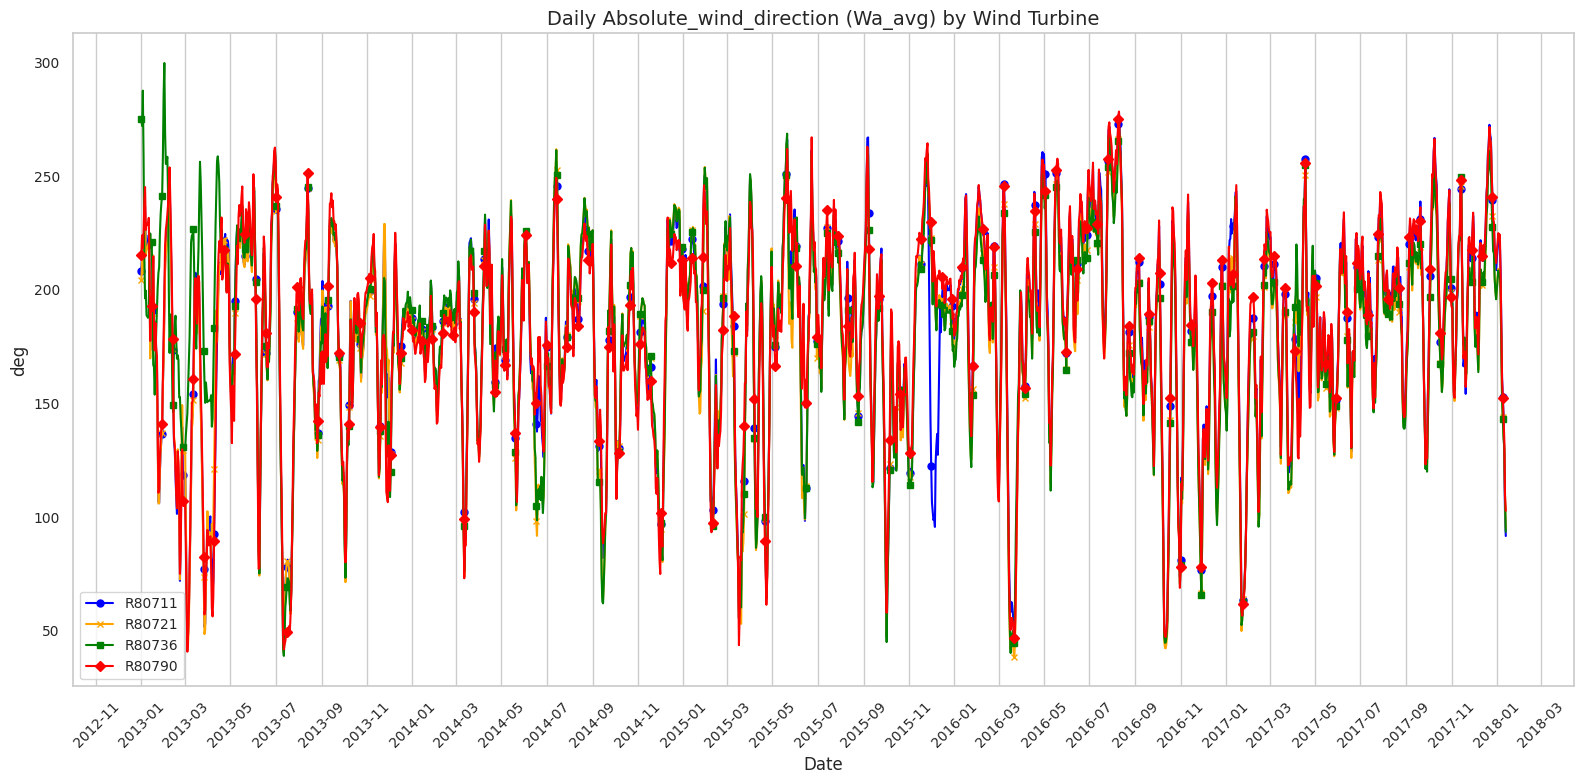

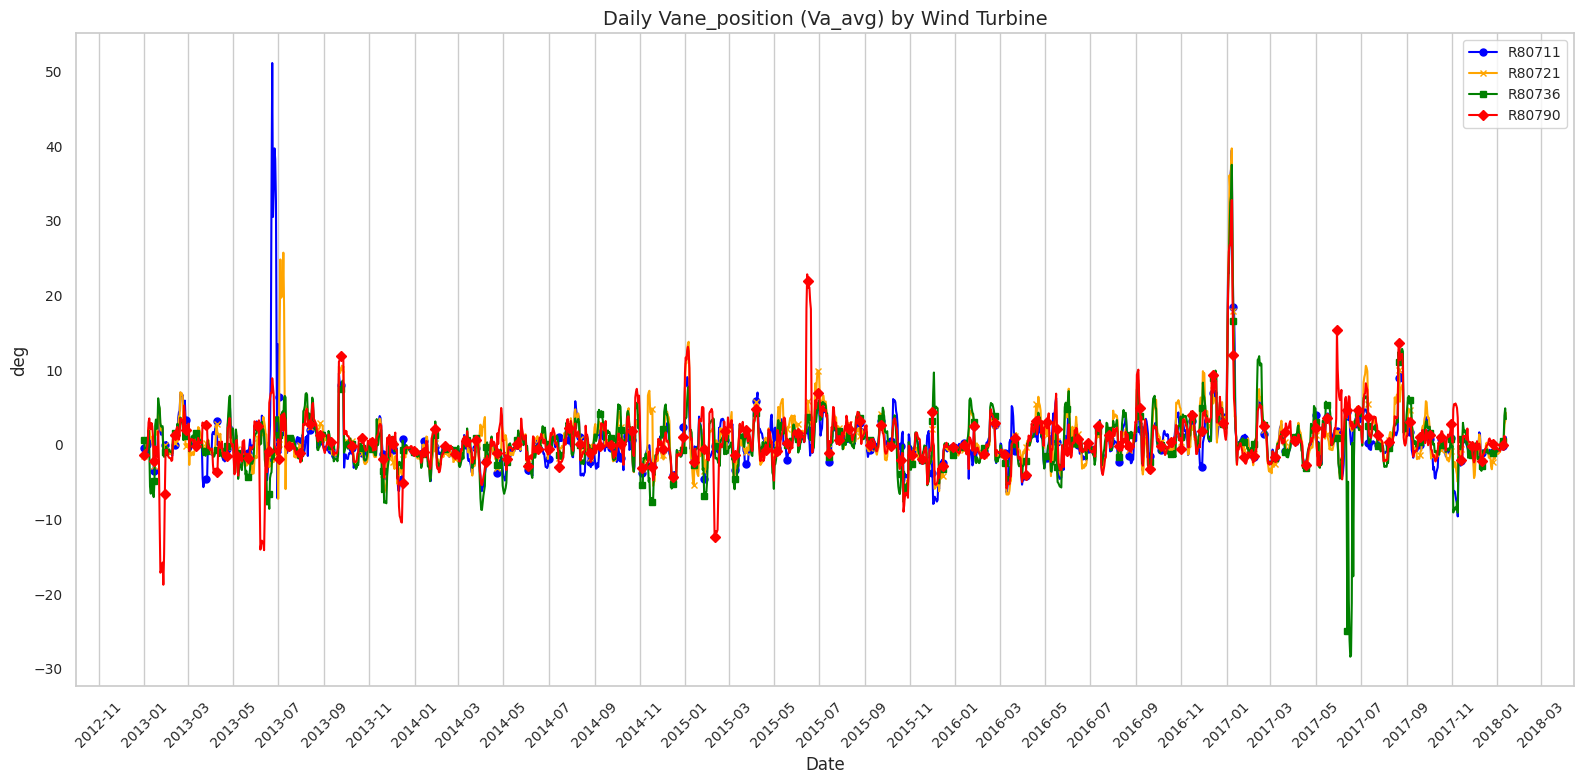

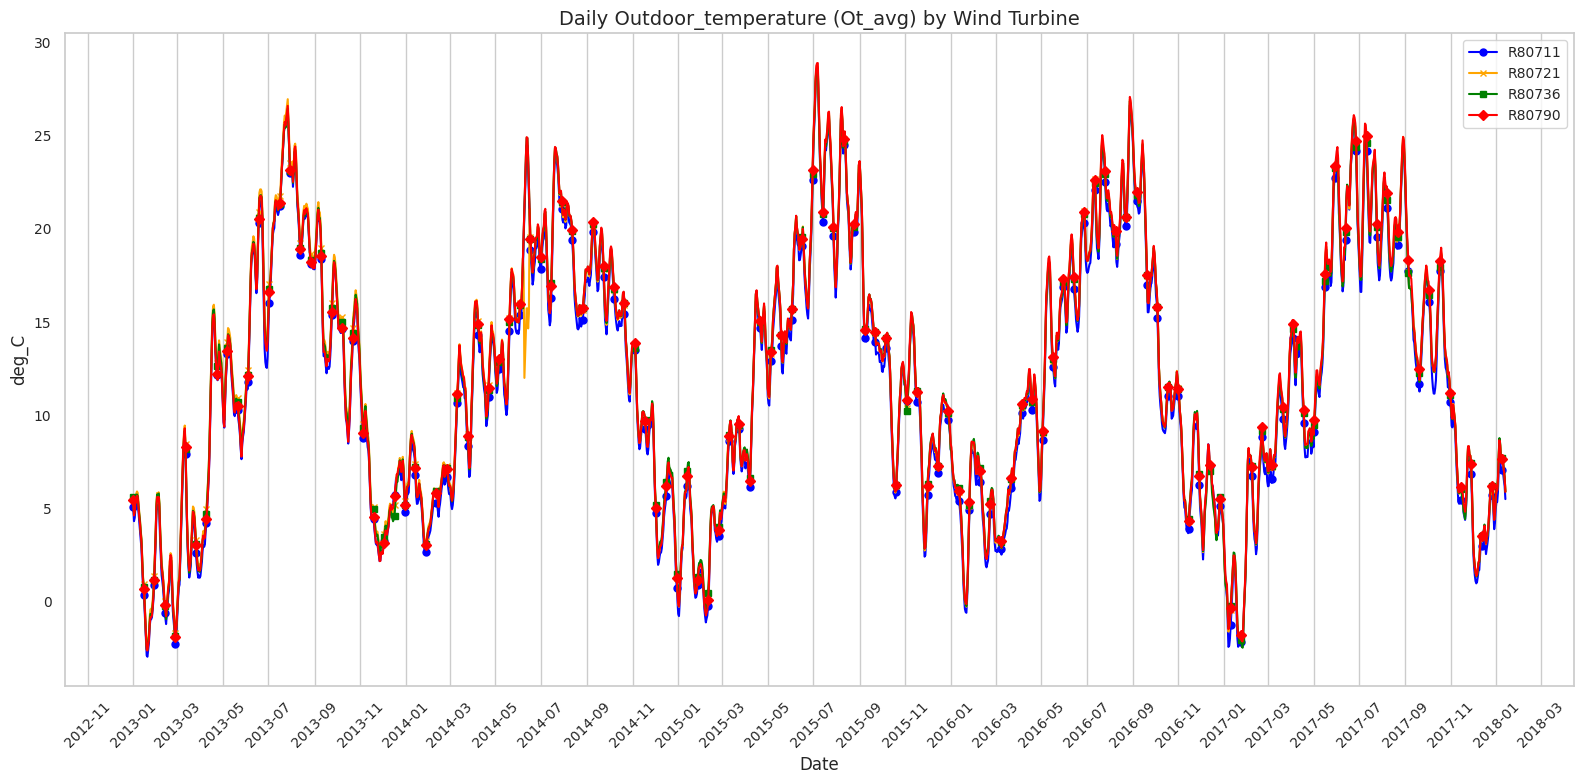

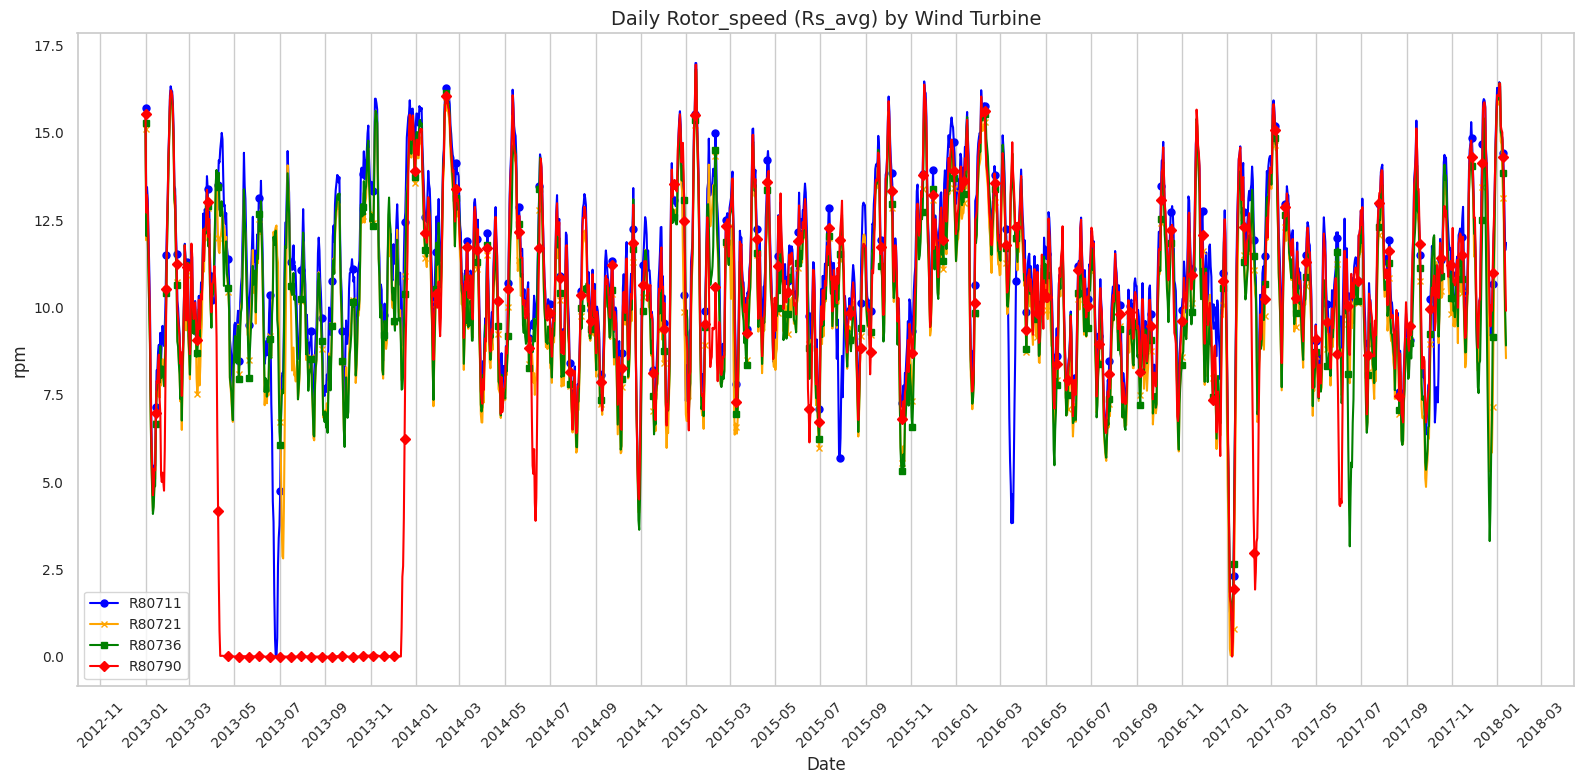

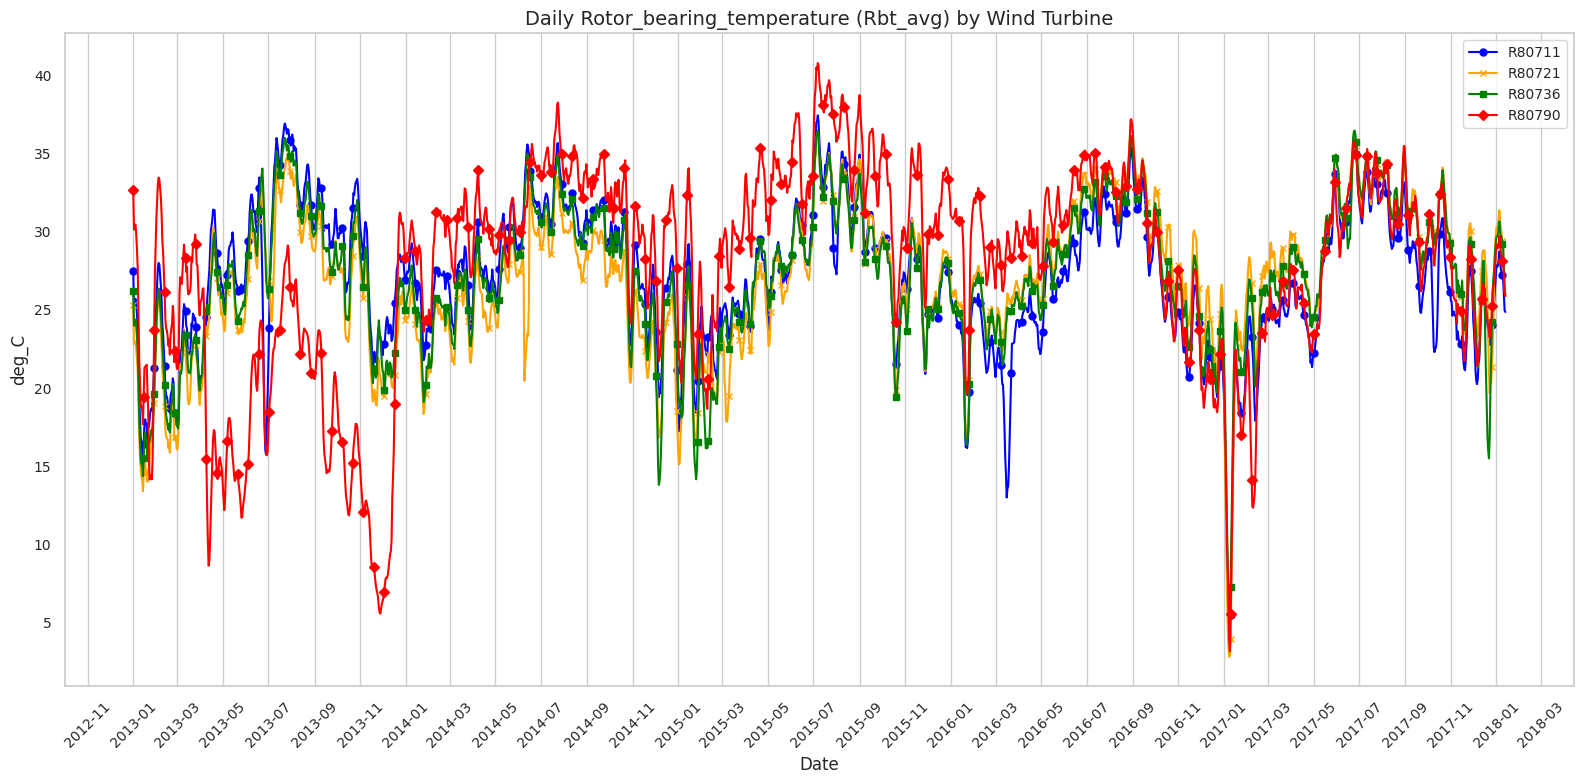

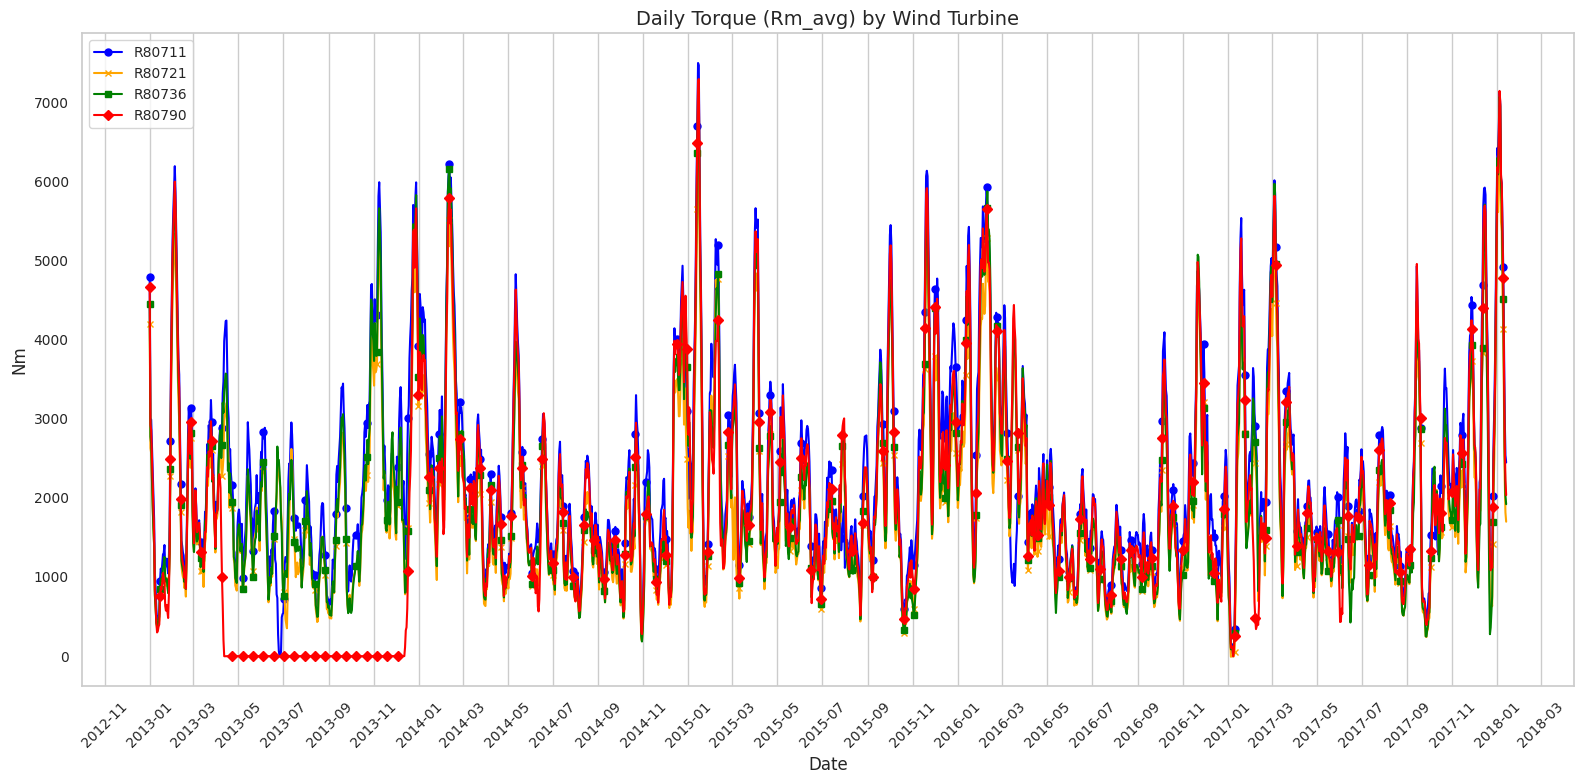

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


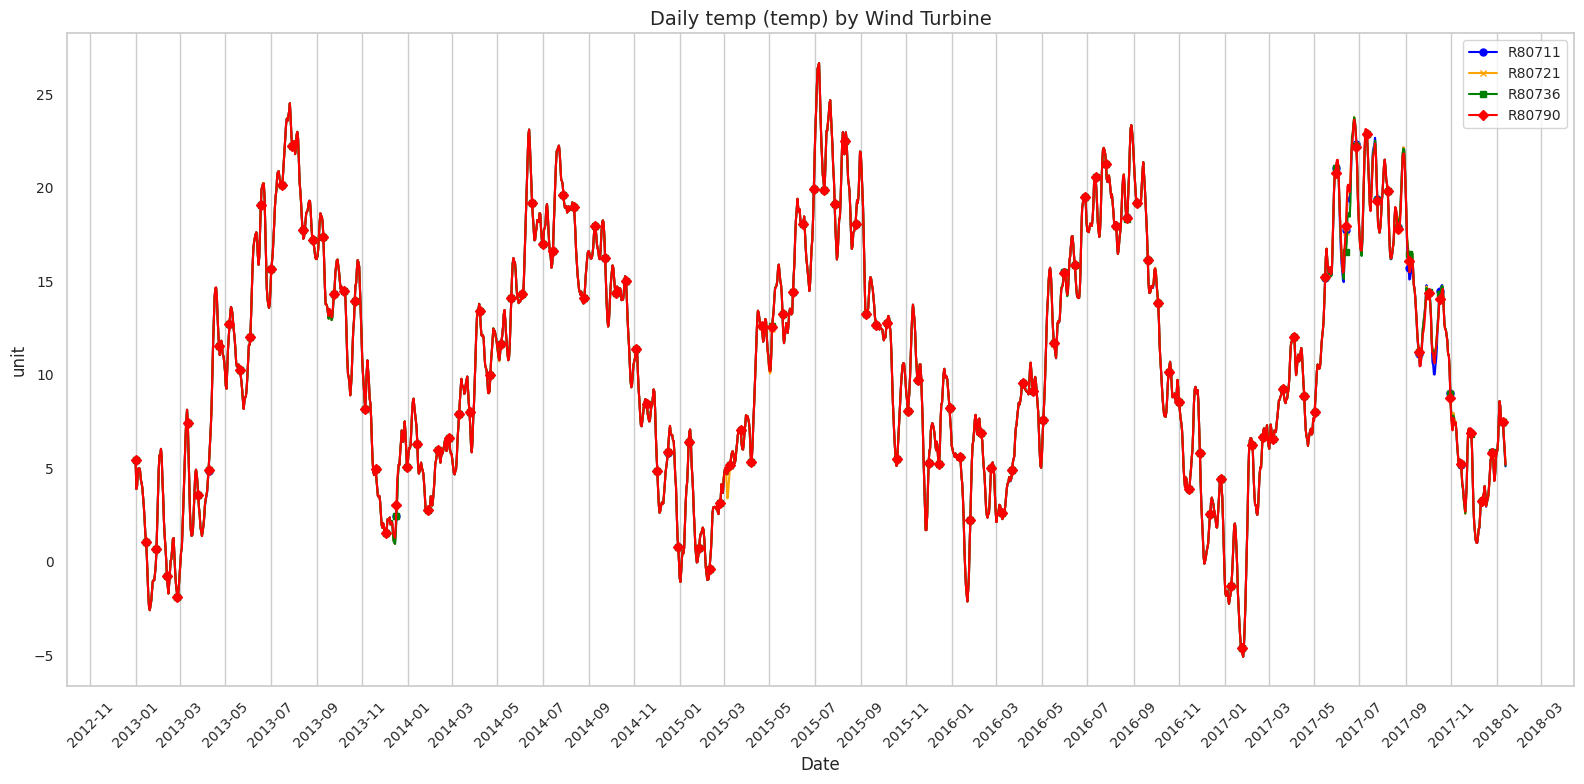

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


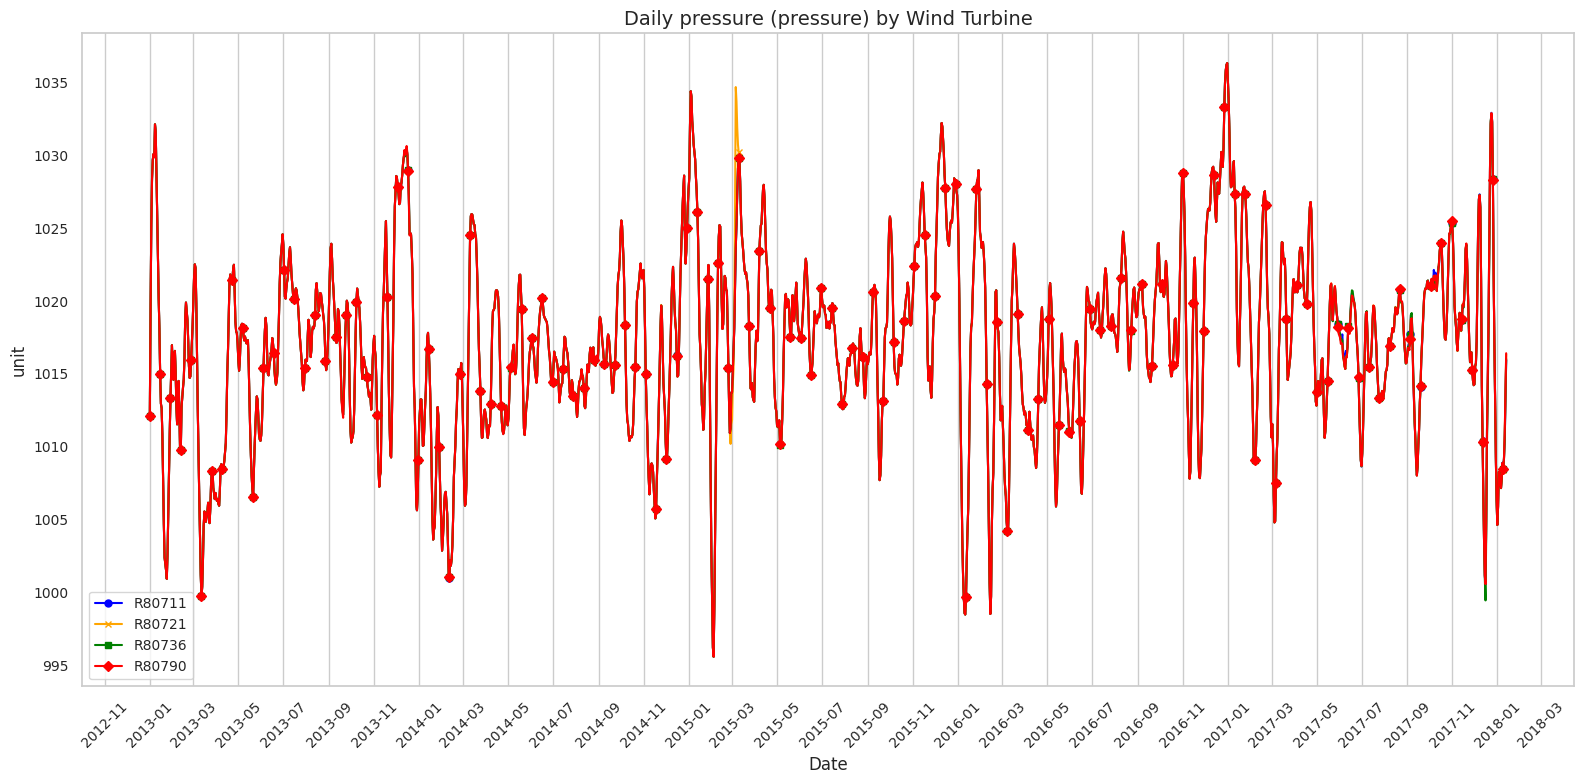

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


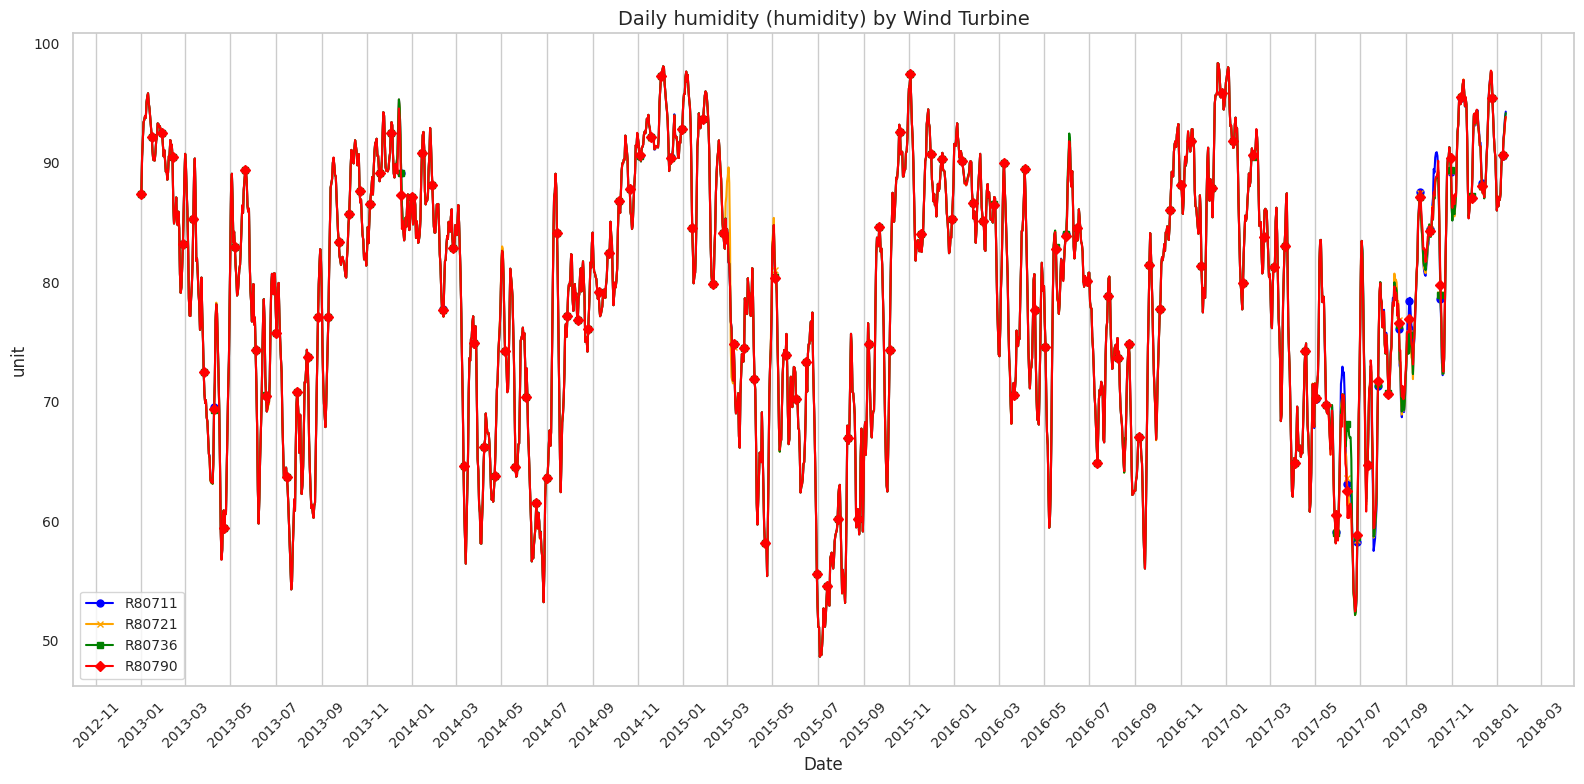

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


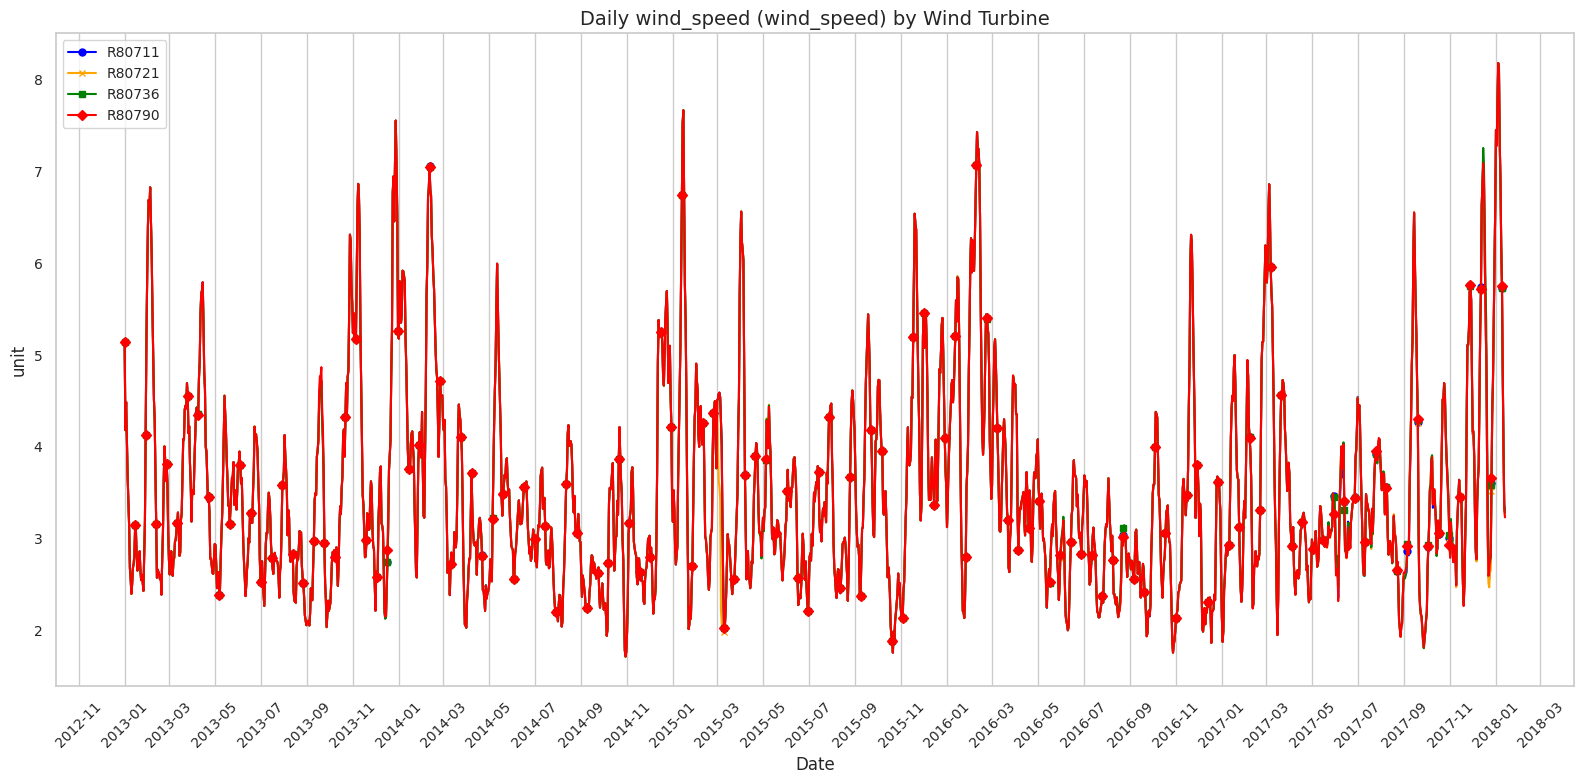

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


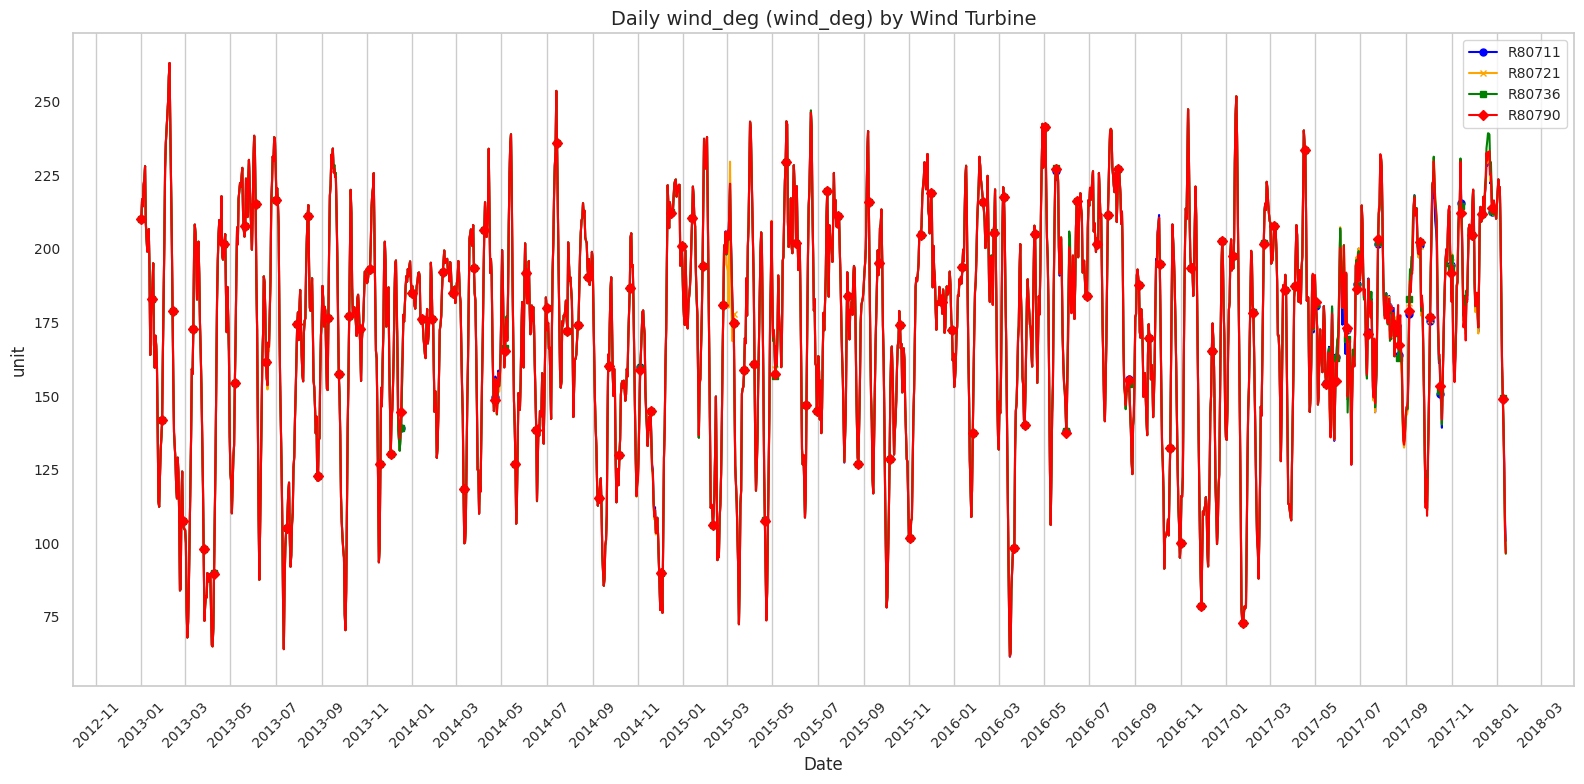

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


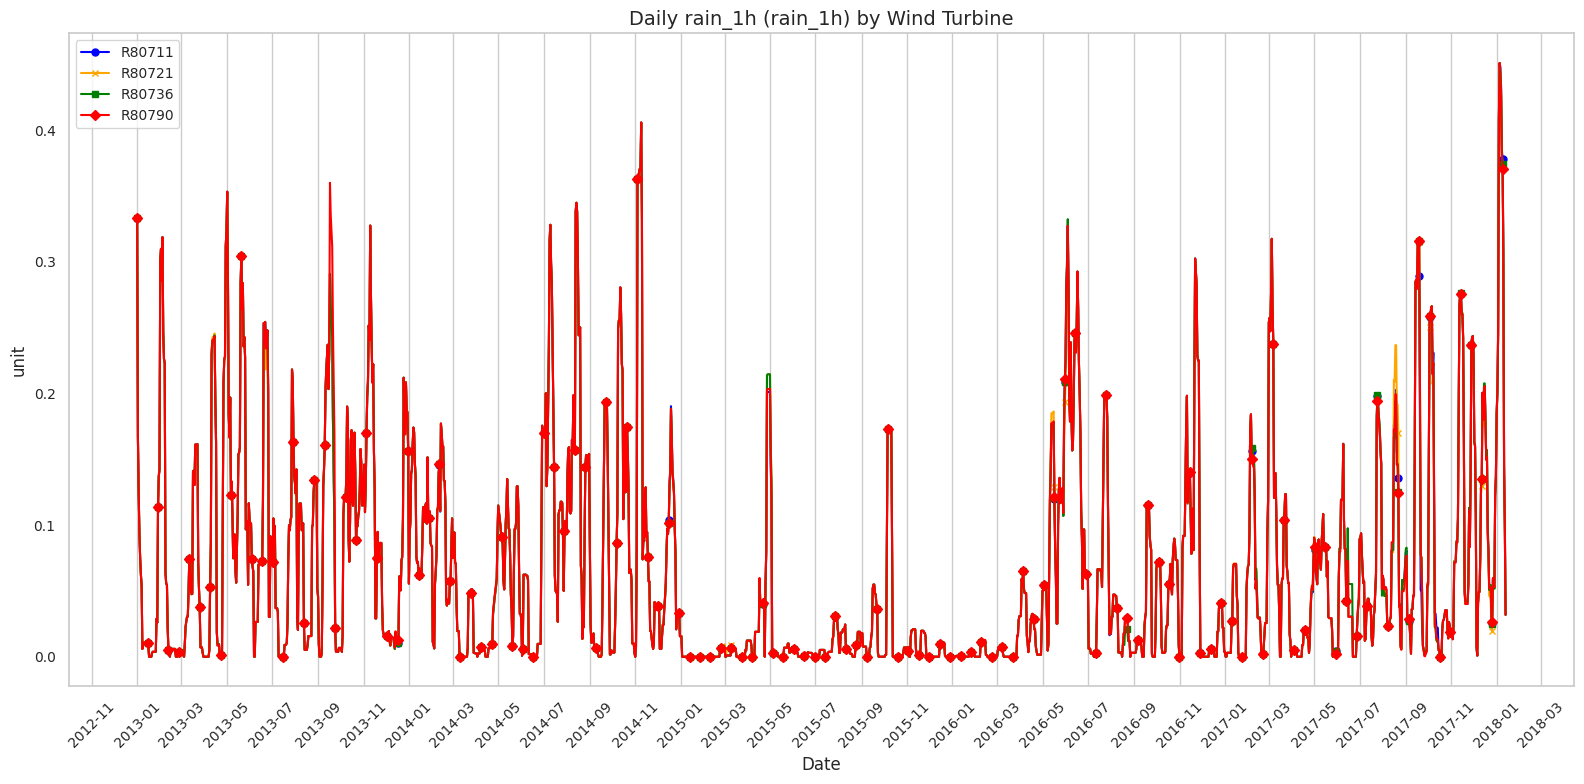

/tmp/ipykernel_734/1983125106.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
/tmp/ipykernel_734/1983125106.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'


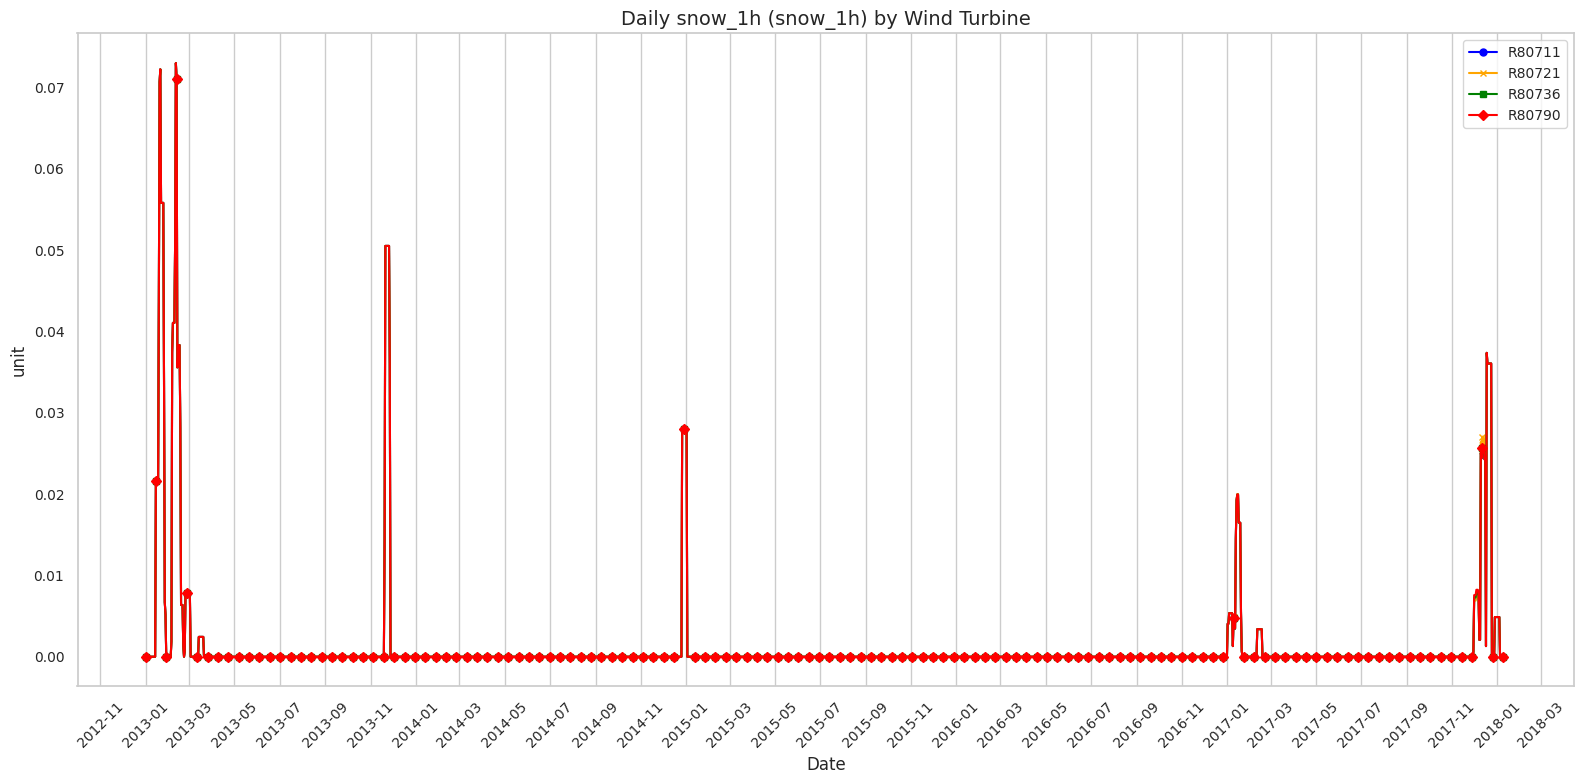

In [15]:
for col_name in filtered_df.columns:

    if col_name == 'Wind_turbine_name':
      continue

    # group df data per day and turbine name
    daily_data = df.groupby('Wind_turbine_name')[col_name].resample('D').mean().reset_index()
    plt.figure(figsize=(16, 8))

    markers = ['o', 'x', 's', 'D']
    colors = ['blue', 'orange', 'green', 'red']

    filtered_dd = data_description[data_description['Variable_name'] == col_name.split('_')[0]]
    long_name = filtered_dd['Variable_long_name'].values[0] if filtered_dd['Variable_long_name'].values else col_name
    unit_name = filtered_dd['Unit_long_name'].values[0] if filtered_dd['Unit_long_name'].values else 'unit'

    # plot data for each turbine
    for i, turbine_name in enumerate(daily_data['Wind_turbine_name'].unique()):
        turbine_data = daily_data[daily_data['Wind_turbine_name'] == turbine_name]

        # smooth the data
        turbine_data_smoothed = turbine_data.set_index('Date_time')[col_name].rolling(window='7D').mean()
        plt.plot(turbine_data['Date_time'], turbine_data_smoothed, marker=markers[i], linestyle='-',
                markersize=5, markevery=14, color=colors[i], label=turbine_name)

    plt.title(f'Daily {long_name} ({col_name}) by Wind Turbine', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{unit_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y')

    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format to show year-month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # show ticks every 2 months

    # rotate x-axis labels for better readability of dates
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Feature Correlation Exploration; some selection

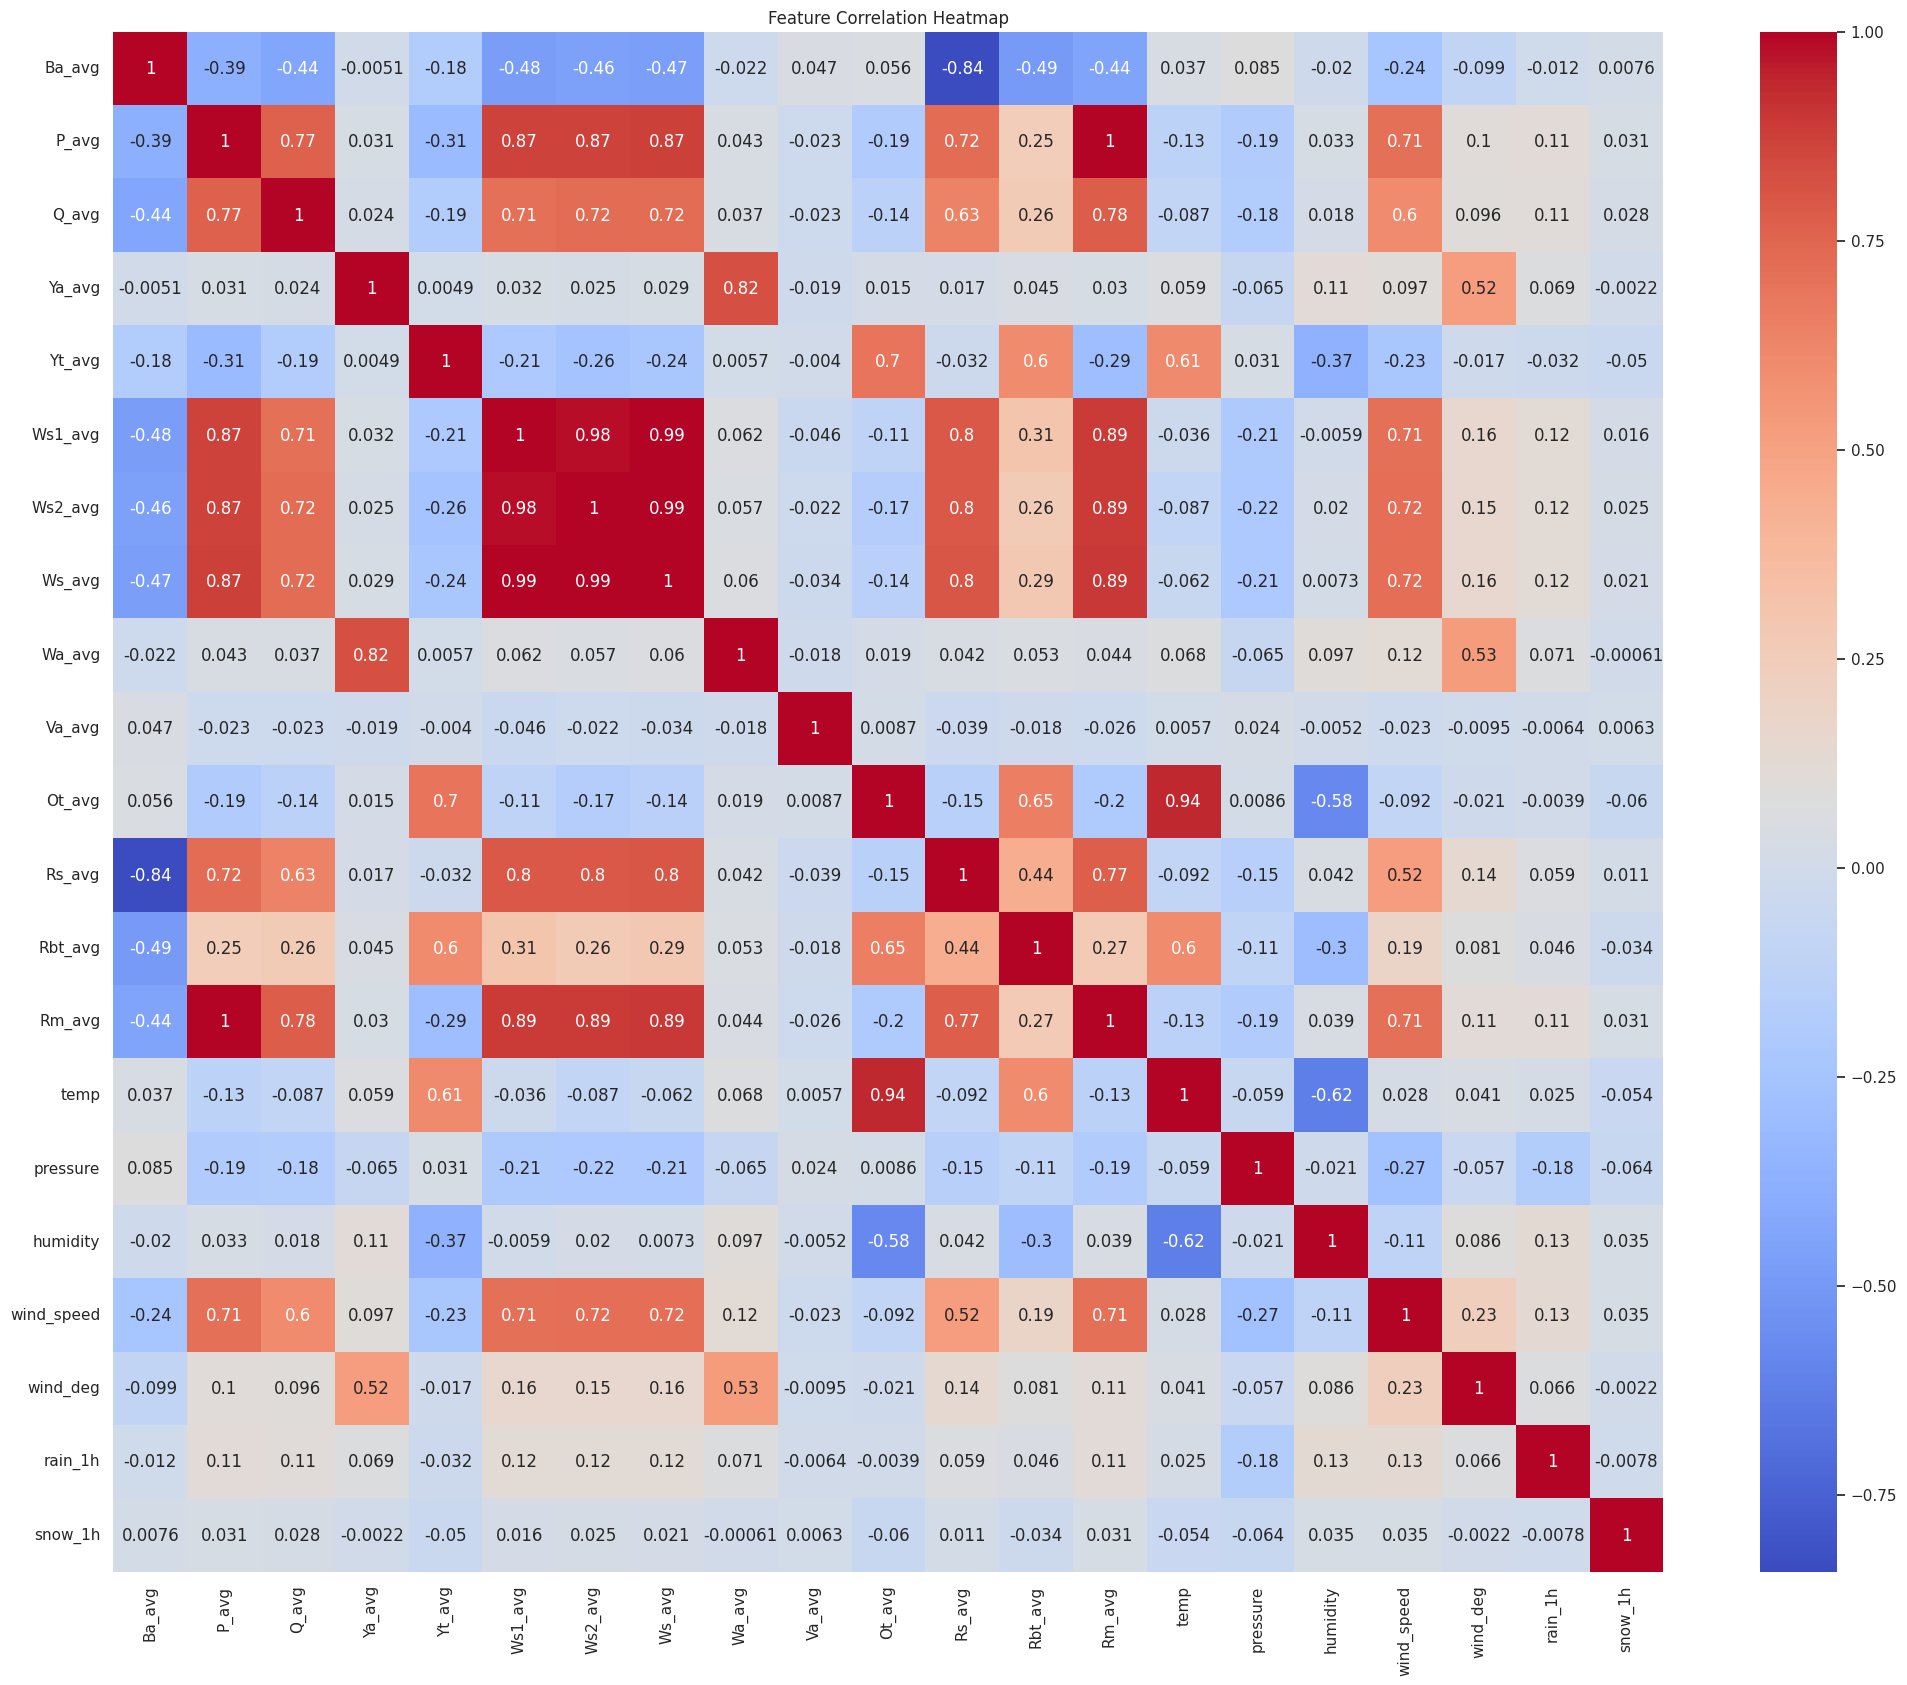

In [16]:
# calculate and plot correlation matrix
temp_df = df.drop(columns=['Date_time_nr', 'Wind_turbine_name'])
correlation_matrix = temp_df.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

- ```P_avg``` (active power) is highly correlated with ```Ws_avg```, ```Ws1_avg```, ```Ws2_avg``` (wind speeds), and ```Rm_avg``` (rotor torque). This is expected, as higher wind speeds typically lead to higher power generation and torque.

- ```Ws_avg```, ```Ws1_avg```, and ```Ws2_avg``` (wind speeds) are extremely highly correlated with each other (almost perfectly). This suggests redundancy, as they are measuring essentially the same thing.

- ```Rm_avg``` (rotor torque) is also strongly correlated with the wind speeds, indicating a direct relationship.

- ```temp``` is highly correlated with ```Ot_avg``` (outdoor temperature).

- ```wind_speed``` is highly correlated with ```Ws_avg```, ```Ws1_avg```, ```Ws2_avg``` (wind speeds).

- ```Ba_avg``` (pitch angle) is moderately negatively correlated with ```P_avg``` and wind speeds. This is expected, as higher pitch angles are used to control power output in strong winds.

 - ```P_avg``` is moderately negatively correlated with ```temp``` and ```Ot_avg```, which could indicate that lower temperatures might slightly decrease the power output.

#### Conclusions on feature selection

It is essential to remove redundant features, as they increase the complexity of our future models. Therefore, here is what will be removed:
- the wind speed measure, for example ```Ws_avg``` will be kept, ```Ws1_avg```, ```Ws2_avg``` and ```wind_speed``` will be removed.
- ```temp``` and ```Ot_avg``` are the same thing, only ```Ot_avg``` will be kept.

In [17]:
before = len(df.columns)
filtered_df = filtered_df.drop(columns=['Ws1_avg', 'Ws2_avg', 'wind_speed', 'temp'])
print(f'From {before} features, we have now {len(filtered_df.columns)} important features to work with.')

From 23 features, we have now 18 important features to work with.


# Anomaly Detection

#### Stationarity test

Important to test if data is stationary, since a lot of models assume stationarity of time series data.

In [18]:
from statsmodels.tsa.stattools import adfuller

daily_data = temp_df.resample('D').mean().reset_index()

nonstationary_data = []
for col_name in temp_df.columns:
    adf_result = adfuller(daily_data[col_name])
    if adf_result[1] >= 0.05:
        nonstationary_data.append(col_name)

if len(nonstationary_data) == 0:
    print('data is stationary')
else:
    print(f'These feature are not stationary: {nonstationary_data}')

data is stationary


#### Training

In [23]:
daily_data = filtered_df.drop(columns=['Wind_turbine_name'])
daily_data = daily_data.resample('D').mean()

# add lagged features
for lag in range(1, 4):
    daily_data[f'P_avg_lag_{lag}'] = daily_data['P_avg'].shift(lag)

# add day of the week and month as features
daily_data['day_of_week'] = daily_data.index.dayofweek
daily_data['month'] = daily_data.index.month

# filter out rows with missing values (introduced by lagging)
daily_data = daily_data.dropna()

# select features and target variable
target_variable = 'P_avg'
features = daily_data.columns.drop([target_variable])
X = daily_data[features]
y = daily_data[target_variable]

param_grid = {
    'n_estimators': [1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],
}

xgb_model = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# perform grid search with time series cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)
grid_search.fit(X, y)

# best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f'Best parameters: {best_params}')

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 1, 'subsample': 0.9}


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.9}

In [27]:
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 1, 'subsample': 0.9}

In [28]:
daily_data = filtered_df.drop(columns=['Wind_turbine_name'])
daily_data = daily_data.resample('D').mean()

# add lagged features
for lag in range(1, 4):
    daily_data[f'P_avg_lag_{lag}'] = daily_data['P_avg'].shift(lag)

# add day of the week and month as features
daily_data['day_of_week'] = daily_data.index.dayofweek
daily_data['month'] = daily_data.index.month

# filter out rows with missing values (introduced by lagging)
daily_data = daily_data.dropna()

# retrain with best parameters and track performance
target_variable = 'P_avg'
features = daily_data.columns.drop([target_variable])
X = daily_data[features]
y = daily_data[target_variable]

tscv = TimeSeriesSplit(n_splits=5)
results = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train XGBoost model with best hyperparameters
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=best_params['colsample_bytree'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        reg_lambda=best_params['reg_lambda'],
        subsample=best_params['subsample'],
        random_state=42
    )

    xgb_model.fit(X_train, y_train, verbose=0)
    y_pred = xgb_model.predict(X_test)

    # eval model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Fold': test_index[0], 'MSE': mse, 'MAE': mae, 'R^2': r2})

results_df = pd.DataFrame(results)
print("\nXGBoost Performance:")
print(results_df[['MSE', 'MAE', 'R^2']].describe().to_markdown(numalign='left', stralign='left'))

# feature importance
importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)



XGBoost Performance:
|       | MSE     | MAE     | R^2        |
|:------|:--------|:--------|:-----------|
| count | 5       | 5       | 5          |
| mean  | 441.736 | 9.38447 | 0.995863   |
| std   | 432.852 | 3.46559 | 0.00470125 |
| min   | 109.529 | 6.55612 | 0.987736   |
| 25%   | 163.165 | 6.57593 | 0.995979   |
| 50%   | 232.283 | 8.6903  | 0.997748   |
| 75%   | 550.835 | 10.1385 | 0.998817   |
| max   | 1152.87 | 14.9615 | 0.999037   |
        Feature  Importance
10       Rm_avg    0.994985
4        Ws_avg    0.003209
1         Q_avg    0.000547
8        Rs_avg    0.000519
0        Ba_avg    0.000215
12     humidity    0.000058
13     wind_deg    0.000057
19  day_of_week    0.000057
7        Ot_avg    0.000042
2        Ya_avg    0.000040
9       Rbt_avg    0.000033
14      rain_1h    0.000032
16  P_avg_lag_1    0.000030
3        Yt_avg    0.000029
5        Wa_avg    0.000029
17  P_avg_lag_2    0.000026
18  P_avg_lag_3    0.000022
6        Va_avg    0.000021
11     pressure 

#### Evaluation

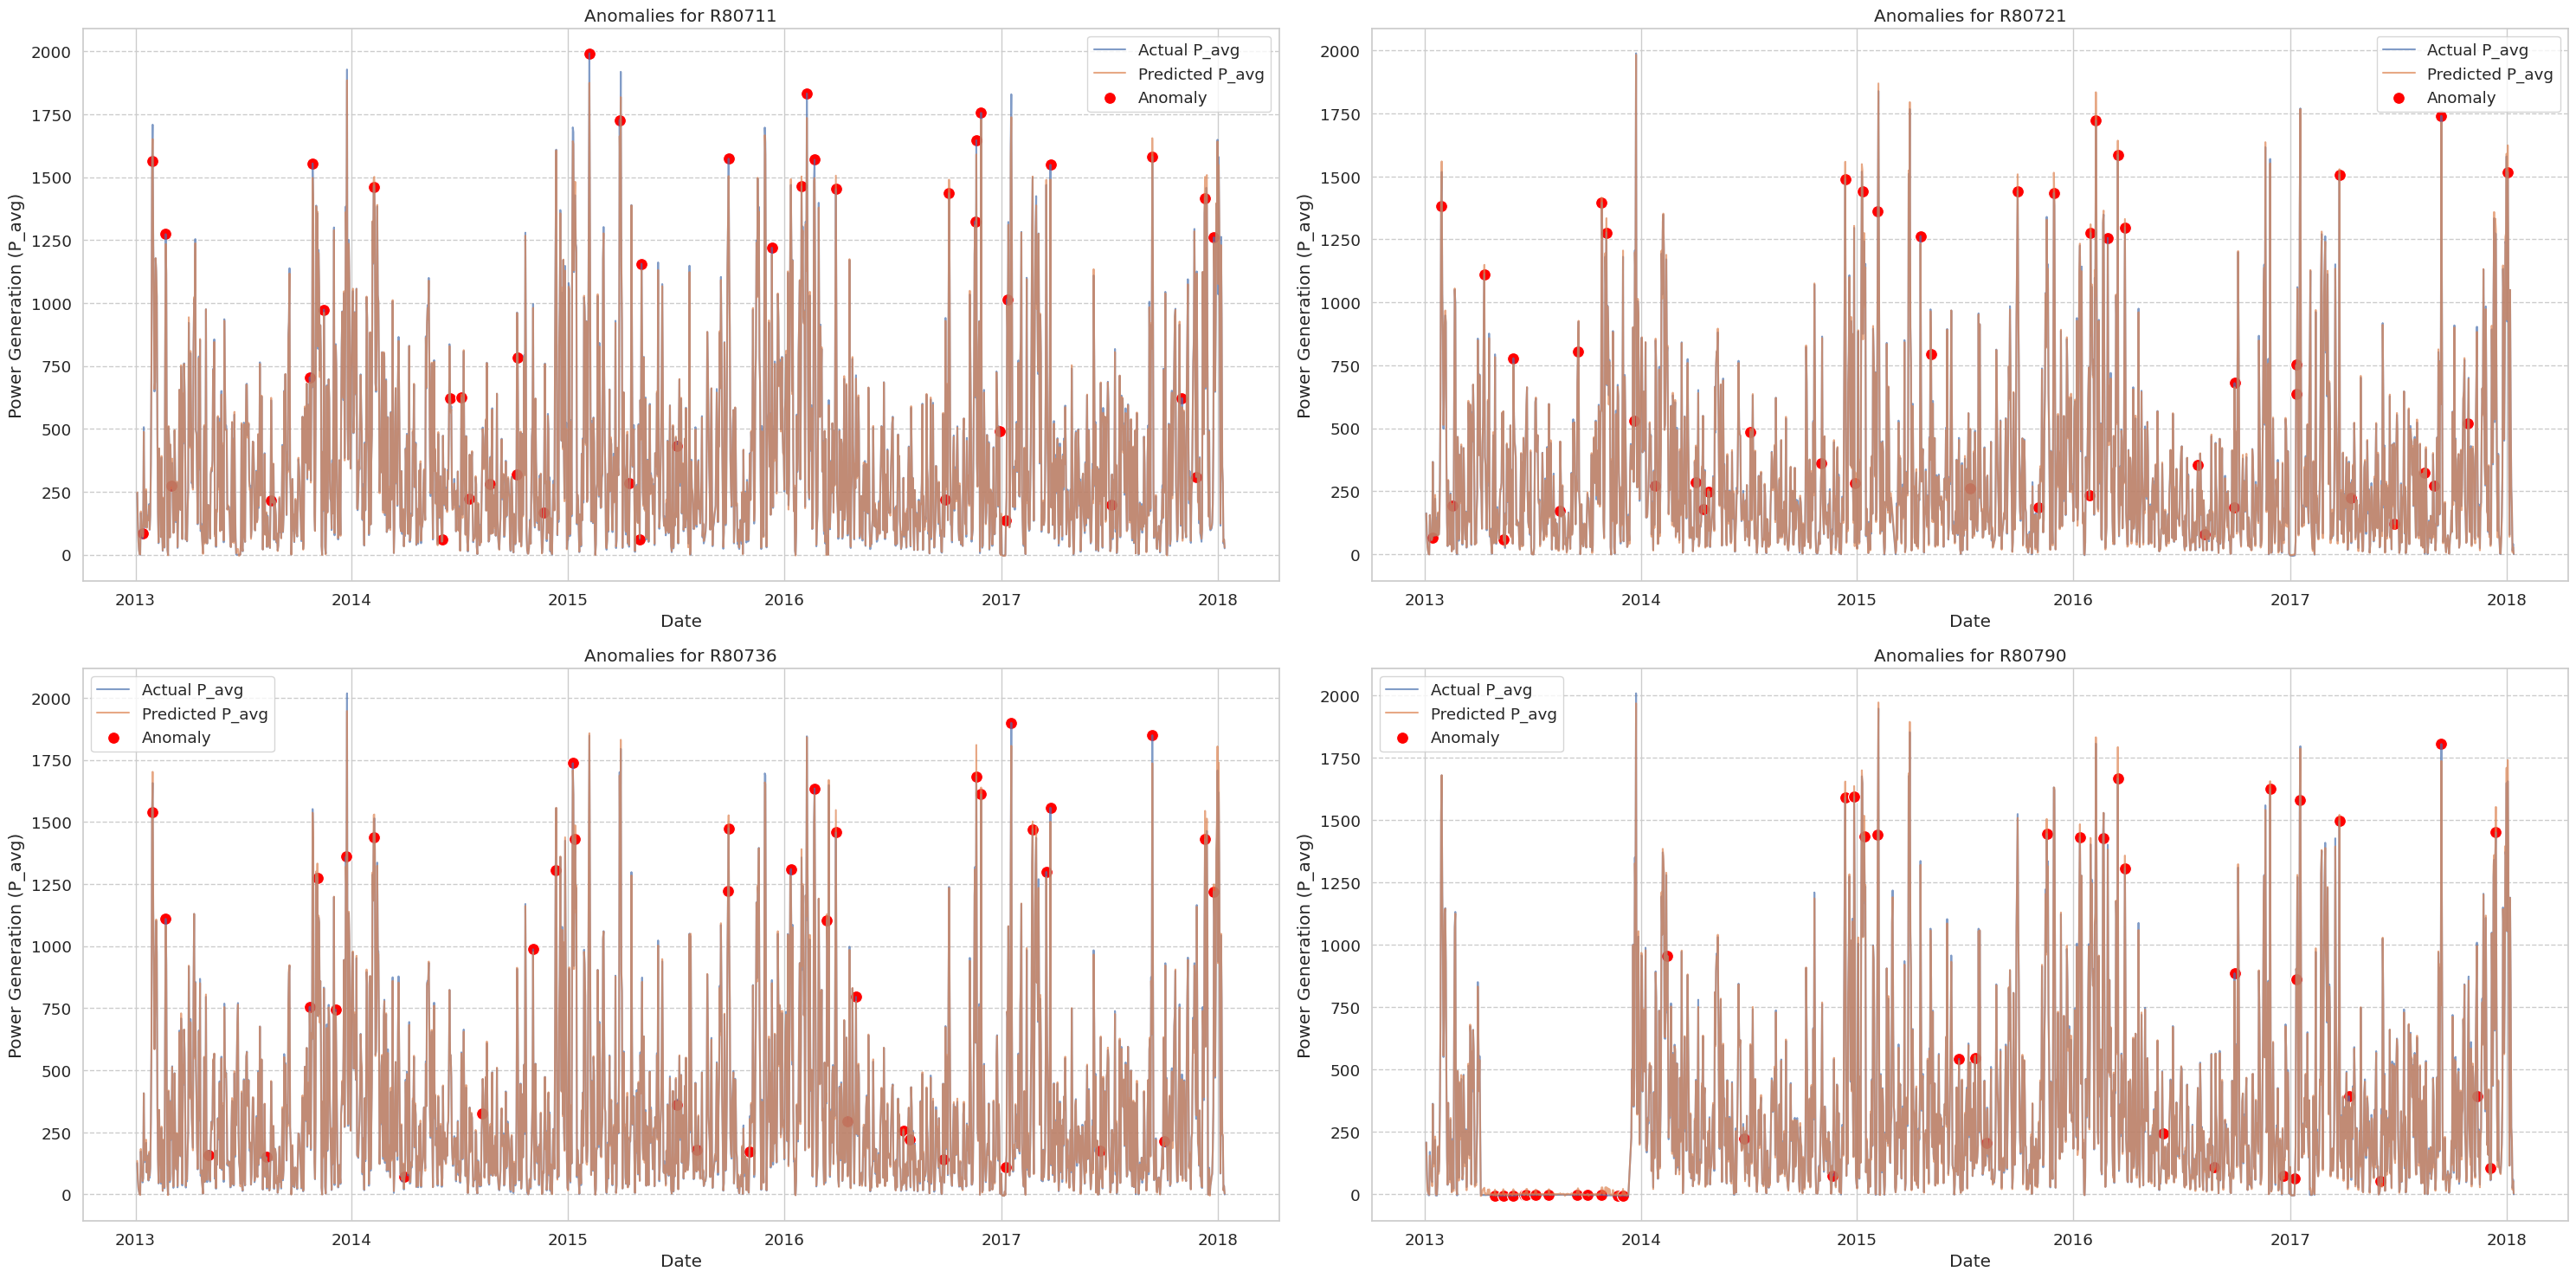

In [29]:
plt.figure(figsize=(30, 15))
sns.set(style="whitegrid", font_scale=1.2)

# plotting anomalies for each turbine
for i, (turbine_name, group) in enumerate(filtered_df.groupby('Wind_turbine_name')):
    group = group.drop(columns=['Wind_turbine_name'])
    group = group.resample('D').mean()

    # add lagged features
    for lag in range(1, 4):
        group[f'P_avg_lag_{lag}'] = group['P_avg'].shift(lag)

    # add day of the week and month as features
    group['day_of_week'] = group.index.dayofweek
    group['month'] = group.index.month

    # filter out rows with missing values (introduced by lagging)
    group = group.dropna()

    # predict `P_avg` using the trained xgboost model
    group['P_avg_predicted_xgb'] = xgb_model.predict(group[X.columns])

    # calculate residuals
    group['residuals_xgb'] = group['P_avg'] - group['P_avg_predicted_xgb']

    # calculate rolling mean and standard deviation of residuals
    window_size = 7
    group['residuals_xgb_rolling_mean'] = group["residuals_xgb"].transform(
        lambda x: x.rolling(window=window_size).mean()
    )
    group['residuals_xgb_rolling_std'] = group["residuals_xgb"].transform(
        lambda x: x.rolling(window=window_size).std()
    )

    # calculate z-scores of residuals
    group['z_score_xgb'] = (group['residuals_xgb'] - group['residuals_xgb_rolling_mean']) / group['residuals_xgb_rolling_std']
    z_threshold = 2

    # filter anomalies
    group['anomaly'] = group['z_score_xgb'].abs() > z_threshold

    plt.subplot(2, 2, i + 1)

    # predicted and actual power
    sns.lineplot(x=group.index, y='P_avg', data=group, label='Actual P_avg', alpha=0.7)
    sns.lineplot(x=group.index, y='P_avg_predicted_xgb', data=group, label='Predicted P_avg', alpha=0.7)

    # scatterplot for anomalies
    anomalies = group[group['anomaly']]
    if not anomalies.empty:
        sns.scatterplot(
            x=anomalies.index,
            y='P_avg',
            data=anomalies,
            s=100,
            color='red',
            label='Anomaly',
        )

    plt.title(f'Anomalies for {turbine_name}')
    plt.xlabel('Date')
    plt.ylabel('Power Generation (P_avg)')
    plt.legend()
    plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
